# P4 - Anticipez les besoins en consommation électrique de bâtiments

## 1. Objectifs

###  Feuille de route

In [885]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  StandardScaler, RobustScaler, MinMaxScaler
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.model_selection import train_test_split
import time
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, \
    explained_variance_score, median_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [886]:
#chargement dataset
data=pd.read_csv('data_clean.csv')

In [887]:
# copie dataset
df=data.copy()

In [888]:
# intitulés des colonnes
df.columns

Index(['Unnamed: 0', 'osebuildingid', 'buildingtype', 'primarypropertytype',
       'councildistrictcode', 'neighborhood', 'numberofbuildings',
       'numberoffloors', 'largestpropertyusetype',
       'secondlargestpropertyusetype', 'thirdlargestpropertyusetype',
       'energystarscore', 'siteenergyuse(kbtu)', 'totalghgemissions',
       'address', 'zipcode', 'age', 'log_siteenergyuse(kbtu)',
       'log_totalghgemissions', 'taux_parking_gfa', 'nombre_utilisation',
       'taux-largest_gfa', 'taux_second_gfa', 'taux_third_gfa',
       'log_propertygfabuilding', 'lat_long'],
      dtype='object')

In [889]:
# supprimer les colonnes inutiles
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [890]:
# vérification des NAN par sécurité
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   osebuildingid                 1679 non-null   int64  
 1   buildingtype                  1679 non-null   object 
 2   primarypropertytype           1679 non-null   object 
 3   councildistrictcode           1679 non-null   int64  
 4   neighborhood                  1679 non-null   object 
 5   numberofbuildings             1679 non-null   float64
 6   numberoffloors                1679 non-null   float64
 7   largestpropertyusetype        1679 non-null   object 
 8   secondlargestpropertyusetype  1679 non-null   object 
 9   thirdlargestpropertyusetype   1679 non-null   object 
 10  energystarscore               1111 non-null   float64
 11  siteenergyuse(kbtu)           1679 non-null   float64
 12  totalghgemissions             1679 non-null   float64
 13  add

In [891]:
# mettre de coté les variables de géolocalisation
identification_features = ['osebuildingid', 'address', 'zipcode','lat_long','neighborhood']
df_identification = df[identification_features]
df.drop(df_identification,axis=1,inplace=True)

In [533]:
# dimension du data avant début de preprocessing
df.shape

(1679, 20)

# 2. Preprocessing 

## 2.1 Matrice X et vecteur y

In [534]:
# Suppression de la variable 'ENERGYSTARScore' à étudier pour l'émission de Co2
cols_energystar = 'energystarscore'
# Suppression de cette variable du dataframe à modéliser
df.drop([cols_energystar], axis=1, inplace=True)

In [535]:
# Catégoriser les variables 
categorical_columns = df.select_dtypes(['object']).columns.tolist()
numerical_columns =  df.select_dtypes(['int64','float64']).columns.tolist()
# supprimer les variables cibles 
numerical_columns.remove('siteenergyuse(kbtu)')
numerical_columns.remove('log_siteenergyuse(kbtu)')
numerical_columns.remove('totalghgemissions')
numerical_columns.remove('log_totalghgemissions')

In [536]:
numerical_columns

['councildistrictcode',
 'numberofbuildings',
 'numberoffloors',
 'age',
 'taux_parking_gfa',
 'nombre_utilisation',
 'taux-largest_gfa',
 'taux_second_gfa',
 'taux_third_gfa',
 'log_propertygfabuilding']

### MATRICE X

In [537]:
X = df[categorical_columns+numerical_columns]
X.shape

(1679, 15)

### VECTEUR y

In [538]:
y_energy=df['log_siteenergyuse(kbtu)']
y_emission=df['log_totalghgemissions']

## 2.2 Découpage du jeu de données en train set et test set

### Target energy

In [539]:
X_train, X_test, y_energy_train, y_energy_test = train_test_split(X, y_energy, test_size=0.2, random_state=30)
    
print(f'X_train : {X_train.shape} - X_test : {X_test.shape}')
print(f'y_energy_train : {y_energy_train.shape} - y_energy_test : {y_energy_test.shape}')

X_train : (1343, 15) - X_test : (336, 15)
y_energy_train : (1343,) - y_energy_test : (336,)


### Target emission CO2

In [540]:
X_train, X_test, y_emission_train, y_emission_test = train_test_split(X, y_emission, test_size=0.2, random_state=30)
    
print(f'X_train : {X_train.shape} - X_test : {X_test.shape}')
print(f'y_emission_train : {y_emission_train.shape} - y_emission_test : {y_emission_test.shape}')

X_train : (1343, 15) - X_test : (336, 15)
y_emission_train : (1343,) - y_emission_test : (336,)


## 2.2 Encodage et standardisation

### Encodage des variavbles qualitatives 

In [541]:
# Utilisation de OneHotEncoder()
ohe=OneHotEncoder(sparse=False,handle_unknown='ignore')

In [542]:
X_train[categorical_columns].nunique()

buildingtype                     5
primarypropertytype             23
largestpropertyusetype          57
secondlargestpropertyusetype    45
thirdlargestpropertyusetype     35
dtype: int64

In [543]:
# Encodage
X_train_cat = ohe.fit_transform(X_train[categorical_columns])
X_train_cat = pd.DataFrame(columns=ohe.get_feature_names().tolist(),
                        data=X_train_cat)
X_test_cat= ohe.transform(X_test[categorical_columns])
X_test_cat = pd.DataFrame(columns=ohe.get_feature_names().tolist(),
                        data=X_test_cat)

In [544]:
X_train_cat.head(2)

,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_Distribution Center,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Laboratory,...,x4_Pre-school/Daycare,x4_Refrigerated Warehouse,x4_Restaurant,x4_Retail Store,x4_Self-Storage Facility,x4_Social/Meeting Hall,x4_Supermarket/Grocery Store,x4_Swimming Pool,x4_Worship Facility,x4_unused
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Standardisation des variables quantitatives 

#### MinMax 

       councildistrictcode  numberofbuildings  numberoffloors          age  \
count          1343.000000        1343.000000     1343.000000  1343.000000   
mean              0.567759           0.010760        0.052524     0.464826   
std               0.367421           0.029233        0.081072     0.284554   
min               0.000000           0.000000        0.000000     0.000000   
25%               0.166667           0.009009        0.013158     0.230435   
50%               0.500000           0.009009        0.026316     0.434783   
75%               1.000000           0.009009        0.052632     0.739130   
max               1.000000           1.000000        1.000000     1.000000   

       taux_parking_gfa  nombre_utilisation  taux-largest_gfa  \
count       1343.000000         1343.000000       1343.000000   
mean           0.066692            0.073591          0.160271   
std            0.154972            0.099486          0.065658   
min            0.000000            0.

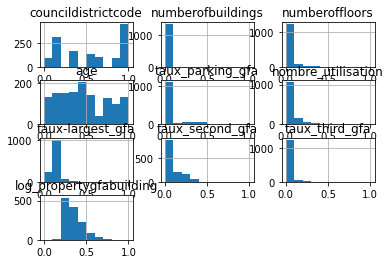

In [545]:
# retrieve just the numeric input values
data = X_train[numerical_columns]
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data,columns =X_train[numerical_columns].columns.tolist())
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
pyplot.show()

#### StandardScaler

       councildistrictcode  numberofbuildings  numberoffloors           age  \
count         1.343000e+03       1.343000e+03    1.343000e+03  1.343000e+03   
mean         -1.078809e-16       1.931730e-16    2.030724e-16 -4.182970e-17   
std           1.000373e+00       1.000373e+00    1.000373e+00  1.000373e+00   
min          -1.545831e+00      -3.682061e-01   -6.481102e-01 -1.634134e+00   
25%          -1.092049e+00      -5.991384e-02   -4.857502e-01 -8.240211e-01   
50%          -1.844860e-01      -5.991384e-02   -3.233902e-01 -1.056189e-01   
75%           1.176859e+00      -5.991384e-02    1.329829e-03  9.643418e-01   
max           1.176859e+00       3.385224e+01    1.169125e+01  1.881451e+00   

       taux_parking_gfa  nombre_utilisation  taux-largest_gfa  \
count      1.343000e+03        1.343000e+03      1.343000e+03   
mean       2.138605e-16        4.454946e-16      3.182694e-17   
std        1.000373e+00        1.000373e+00      1.000373e+00   
min       -4.305091e-01     

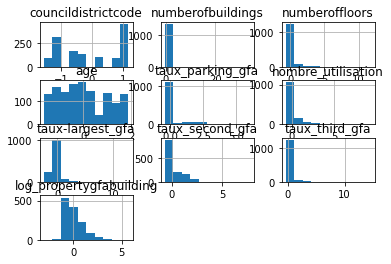

In [546]:
# retrieve just the numeric input values
data = X_train[numerical_columns]
# perform a robust scaler transform of the dataset
trans = StandardScaler()
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data,columns =X_train[numerical_columns].columns.tolist())
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
pyplot.show()

#### RobustScaler()

       councildistrictcode  numberofbuildings  numberoffloors          age  \
count          1343.000000        1343.000000     1343.000000  1343.000000   
mean              0.567759           0.010760        0.052524     0.464826   
std               0.367421           0.029233        0.081072     0.284554   
min               0.000000           0.000000        0.000000     0.000000   
25%               0.166667           0.009009        0.013158     0.230435   
50%               0.500000           0.009009        0.026316     0.434783   
75%               1.000000           0.009009        0.052632     0.739130   
max               1.000000           1.000000        1.000000     1.000000   

       taux_parking_gfa  nombre_utilisation  taux-largest_gfa  \
count       1343.000000         1343.000000       1343.000000   
mean           0.066692            0.073591          0.160271   
std            0.154972            0.099486          0.065658   
min            0.000000            0.

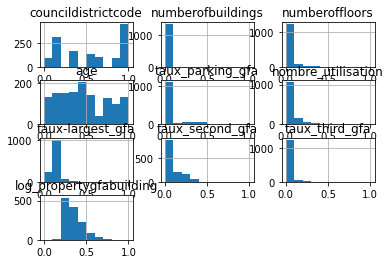

In [547]:
# retrieve just the numeric input values
data = X_train[numerical_columns]
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data,columns =X_train[numerical_columns].columns.tolist())
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
pyplot.show()

In [548]:
# RobustScaler
rbs = RobustScaler()

In [549]:
# fit
X_train_num=rbs.fit_transform(X_train[numerical_columns])
X_test_num=rbs.fit_transform(X_test[numerical_columns])

In [550]:
#remettre en dataframe
X_train_num=pd.DataFrame(X_train_num, columns=X_train[numerical_columns].columns.tolist())
X_test_num=pd.DataFrame(X_test_num,columns=X_test[numerical_columns].columns.tolist() )

In [551]:
# X_train encodé et standardisé
X_train=pd.concat([X_train_num,X_train_cat.reindex(X_train_num.index)],axis=1)

In [552]:
X_train.shape

(1343, 175)

In [553]:
X_train.head()

,councildistrictcode,numberofbuildings,numberoffloors,age,taux_parking_gfa,nombre_utilisation,taux-largest_gfa,taux_second_gfa,taux_third_gfa,log_propertygfabuilding,...,x4_Pre-school/Daycare,x4_Refrigerated Warehouse,x4_Restaurant,x4_Retail Store,x4_Self-Storage Facility,x4_Social/Meeting Hall,x4_Supermarket/Grocery Store,x4_Swimming Pool,x4_Worship Facility,x4_unused
0,-0.6,0.0,-0.333333,0.273504,0.0,-1.0,1.656734,0.000000,0.000000,-0.093710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.2,0.0,0.000000,0.632479,0.0,1.0,-1.436643,1.445916,0.117896,-0.490460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.6,0.0,1.000000,1.111111,0.0,0.0,-0.714203,0.269390,0.000000,-0.155048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,-0.333333,0.051282,0.0,-1.0,0.117207,0.000000,0.000000,0.336524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.6,0.0,0.333333,0.803419,0.0,1.0,-1.384145,1.719048,0.038465,-0.041034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [554]:
# X_test encodé et standardisé
X_test=pd.concat([X_test_num,X_test_cat.reindex(X_test_num.index)],axis=1)

In [555]:
X_test.shape

(336, 175)

In [556]:
X_test.head()

,councildistrictcode,numberofbuildings,numberoffloors,age,taux_parking_gfa,nombre_utilisation,taux-largest_gfa,taux_second_gfa,taux_third_gfa,log_propertygfabuilding,...,x4_Pre-school/Daycare,x4_Refrigerated Warehouse,x4_Restaurant,x4_Retail Store,x4_Self-Storage Facility,x4_Social/Meeting Hall,x4_Supermarket/Grocery Store,x4_Swimming Pool,x4_Worship Facility,x4_unused
0,0.0,0.0,-0.333333,1.065574,0.000000,-1.0,0.157009,0.0,0.0,-0.625471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.6,0.0,-0.666667,0.049180,0.000000,-1.0,0.157009,0.0,0.0,0.861249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.333333,-0.508197,0.000000,-1.0,0.157009,0.0,0.0,-0.154795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.2,0.0,-0.333333,-0.491803,0.608088,0.0,-1.701202,0.0,0.0,0.676494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.4,0.0,-0.333333,0.868852,0.000000,-1.0,0.157009,0.0,0.0,-0.095313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [557]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())


0
0


# 3. Modélisation

# TARGET ENERGY

## 3.1 Modélisation sans optimisation des hyperparamètres 

In [558]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_resultats = pd.DataFrame(dtype='object')

In [559]:
# modèles qui seront testés

mymodels = [LinearRegression(), Ridge(), Lasso(), ElasticNet(),KNeighborsRegressor(), SVR(),RandomForestRegressor(),
           GradientBoostingRegressor()]

In [560]:
# création d'une fonction de regression avec un tableau regroupant les métriques 

def process_regression(model_reg,X_train,X_test,y_train, y_test,df_resultats,titre,tableau=True):

    # Top début d'exécution
    time_start = time.time()

    # Entraînement du modèle
    model_reg.fit(X_train, y_train)
        
    # Prédictions avec le test set
    y_pred = model_reg.predict(X_test)

    # Top fin d'exécution
    time_end = time.time()

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape

    # durée d'exécution
    time_execution = time_end - time_start

    # cross validation
    scoring = ['r2', 'neg_mean_squared_error']
    scores = cross_validate(model_reg, X_train, y_train, cv=5,
                            scoring=scoring, return_train_score=True)

    # Sauvegarde des performances
    df_resultats = df_resultats.append(pd.DataFrame({
         'Modèle': [titre],
         'R2': [r2],
         'MSE': [mse],
         'RMSE': [rmse],
         'MAE': [mae],
         'Accuracy': [accuracy],
         'Time': [time_execution]
     }), ignore_index=True)

    if  tableau:
        display(df_resultats.style.hide_index())

   

    return df_resultats, y_pred


In [561]:
# Régression linéaire non régularisée
df_resultats, y_pred=process_regression(LinearRegression(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'LinearRegression',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264


In [562]:
# Régression linéaire régularisé RIDGE
df_resultats, y_pred=process_regression(Ridge(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'Ridge',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925


In [563]:
# Régression linéaire non régulariséE lASSO
df_resultats, y_pred=process_regression(Lasso(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'Lasso',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947


In [564]:
# Régression linéaire non régularisé ELASTICNET
df_resultats, y_pred=process_regression(ElasticNet(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'ElasticNet',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947
ElasticNet,-0.002627,0.357224,0.597682,0.465865,92.957795,0.011968


In [565]:
# SVR - Support Vector Regressor kernel non lineaire
df_resultats, y_pred=process_regression(SVR(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'SVR',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947
ElasticNet,-0.002627,0.357224,0.597682,0.465865,92.957795,0.011968
SVR,0.756940,0.086600,0.294278,0.219933,96.589389,0.241491


In [566]:
# KNR - KNeighborsRegressor
df_resultats, y_pred=process_regression(KNeighborsRegressor(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'KNeighborsRegressor',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947
ElasticNet,-0.002627,0.357224,0.597682,0.465865,92.957795,0.011968
SVR,0.756940,0.086600,0.294278,0.219933,96.589389,0.241491
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.029919


In [567]:
# RFR -RandomForestRegressor
df_resultats, y_pred=process_regression(RandomForestRegressor(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'RandomForestRegressor',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947
ElasticNet,-0.002627,0.357224,0.597682,0.465865,92.957795,0.011968
SVR,0.756940,0.086600,0.294278,0.219933,96.589389,0.241491
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.029919
RandomForestRegressor,0.718720,0.100217,0.316570,0.232302,96.419770,1.491446


In [568]:
# GBR -GradientBoostingRegressor()
df_resultats, y_pred=process_regression(GradientBoostingRegressor(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'GradientBoostingRegressor',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947
ElasticNet,-0.002627,0.357224,0.597682,0.465865,92.957795,0.011968
SVR,0.756940,0.086600,0.294278,0.219933,96.589389,0.241491
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.029919
RandomForestRegressor,0.718720,0.100217,0.316570,0.232302,96.419770,1.491446
GradientBoostingRegressor,0.746244,0.090410,0.300683,0.224935,96.536563,0.501086


### Bilan

In [569]:
# Comparaison des modèles à travers les métriques choisies

comparatif = df_resultats.sort_values(by=['RMSE', 'R2', 'Time'])
comparatif.style.hide_index()

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
SVR,0.756940,0.086600,0.294278,0.219933,96.589389,0.241491
Ridge,0.748311,0.089674,0.299456,0.227387,96.480618,0.027925
GradientBoostingRegressor,0.746244,0.090410,0.300683,0.224935,96.536563,0.501086
RandomForestRegressor,0.718720,0.100217,0.316570,0.232302,96.419770,1.491446
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.029919
ElasticNet,-0.002627,0.357224,0.597682,0.465865,92.957795,0.011968
Lasso,-0.016363,0.362118,0.601763,0.469268,92.906185,0.018947
LinearRegression,-339303880447603900416.000000,120889993881687670784.000000,10994998584.887934,1224873656.984555,-19257329739.716480,0.079264


In [570]:
# Comparaison visuelle des 7 algorithmes--> nous éliminons le modèle linéaire qui est hors norme
df_compar = comparatif.head(7)
comparaison_score_melt = pd.melt(df_compar, id_vars=['Modèle'], value_name='score', value_vars=[
                                 'MSE', 'R2', 'RMSE', 'Time'])

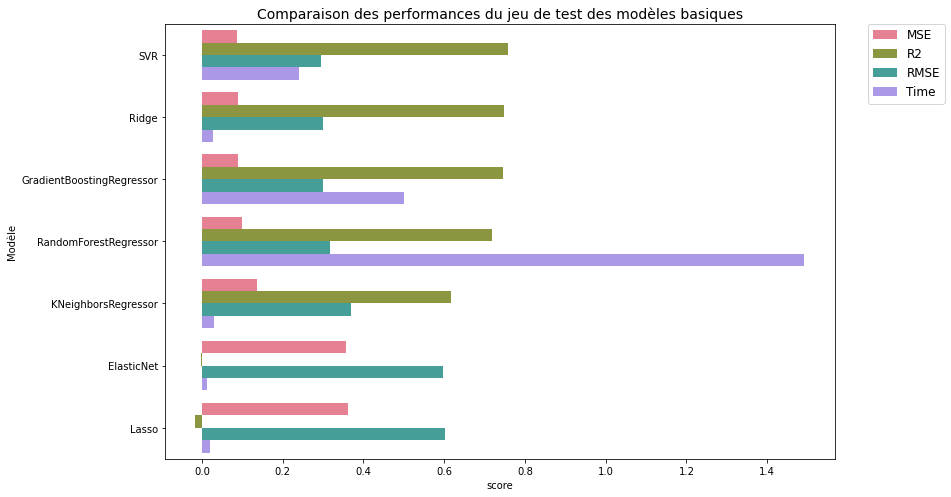

In [571]:
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['score'],
            y=comparaison_score_melt['Modèle'], hue=comparaison_score_melt['variable'],palette='husl')
plt.title(
    'Comparaison des performances du jeu de test des modèles basiques', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

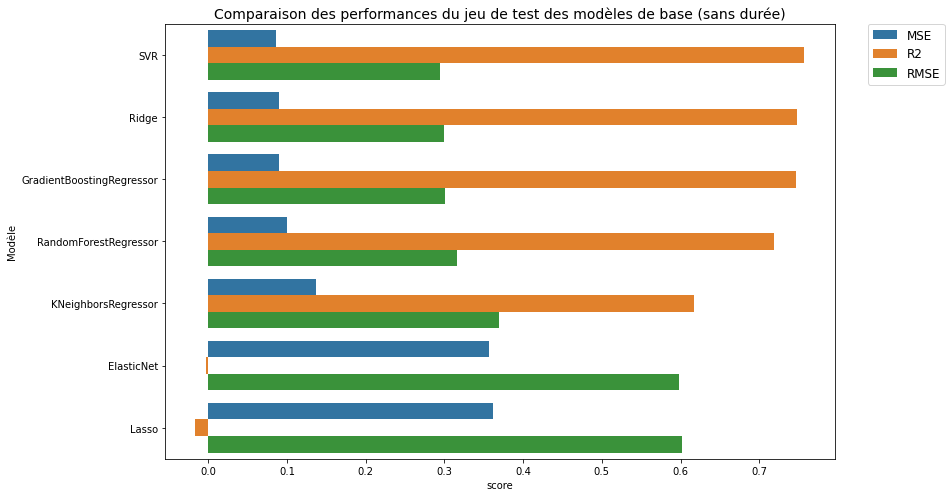

In [572]:
# Comparaison visuelle des  algorithmes  sans la durée
comparaison_score_melt = pd.melt(df_compar, id_vars=[
                                 'Modèle'], value_name='score', value_vars=['MSE', 'R2', 'RMSE'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['score'],
            y=comparaison_score_melt['Modèle'], hue=comparaison_score_melt['variable'])
plt.title(
    'Comparaison des performances du jeu de test des modèles de base (sans durée)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

## 3.2 Modélisation avec optimisation des hyperparamètres 

In [687]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_resultats = pd.DataFrame(dtype='object')

In [688]:
# constitution d'un grid des hyperparametres de chaque modèle --> Modèle de départ arbitraire

ridge_params = {'alpha':[1,0.1,0.01,0.001], 'tol':[0.001]}

lasso_params={'alpha':[0.02, 0.024, 0.025, 0.026, 0.03], 'tol':[0.001]}

elastic_params={'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}

svr_params = {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10],'tol':[0.001]}

knr_params= {'n_neighbors':[3,4,5,6,7,8,9,10,20,30,50]}

rfr_params={'n_estimators' : [10,50,100,300,500],'min_samples_leaf' : [1,3,5,10],'max_features': ['auto', 'sqrt'] }

gradboost_params = {'n_estimators':[10,50,100, 150,200,500]}



In [689]:
# création d'une fonction renvoyant les résultats best_param sur la base des grids choisies

def grid_regression(X_train,y_train,X_test,y_test,estimator, grid,df_resultats,titre,tableau=True):
      
    estimator_grid_energy = GridSearchCV(estimator = estimator(), 
                      param_grid = grid,cv=5,verbose=5)
    
    time_start = time.time()
    
    estimator_grid_energy.fit(X_train, y_train)
   
    
    # Prédictions avec le test set
    y_pred =  estimator_grid_energy.predict(X_test)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Calcul des métriques
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Sauvegarde des performances
    
    df_resultats = df_resultats.append(pd.DataFrame({
         'Modèle': [titre],
          'Best_param':[estimator_grid_energy.best_params_],
        'Best_scor':[estimator_grid_energy.best_score_],
         'Grid R2': [r2],
         'Grid RMSE': [rmse],
         'Grid MAE': [mae],
         'Grid Accuracy': [accuracy],
         'Grid Time': [time_execution]
     }), ignore_index=True)
    
    if tableau:
        display(df_resultats.style.hide_index())
        
    return df_resultats, y_pred   

   

####  RIDGE

In [690]:

df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,Ridge,ridge_params,df_resultats,
                                     'Ridge',tableau=True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................alpha=1, tol=0.001;, score=0.655 total time=   0.0s
[CV 2/5] END ................alpha=1, tol=0.001;, score=0.721 total time=   0.0s
[CV 3/5] END ................alpha=1, tol=0.001;, score=0.734 total time=   0.0s
[CV 4/5] END ................alpha=1, tol=0.001;, score=0.713 total time=   0.0s
[CV 5/5] END ................alpha=1, tol=0.001;, score=0.683 total time=   0.0s
[CV 1/5] END ..............alpha=0.1, tol=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END ..............alpha=0.1, tol=0.001;, score=0.701 total time=   0.0s
[CV 3/5] END ..............alpha=0.1, tol=0.001;, score=0.699 total time=   0.0s
[CV 4/5] END ..............alpha=0.1, tol=0.001;, score=0.674 total time=   0.0s
[CV 5/5] END ..............alpha=0.1, tol=0.001;, score=0.668 total time=   0.0s
[CV 1/5] END .............alpha=0.01, tol=0.001;, score=0.644 total time=   0.0s
[CV 2/5] END .............alpha=0.01, tol=0.001;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479


#### Lasso

In [691]:

df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,Lasso,lasso_params,df_resultats,
                                     'Lasso',tableau=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............alpha=0.02, tol=0.001;, score=0.524 total time=   0.0s
[CV 2/5] END .............alpha=0.02, tol=0.001;, score=0.605 total time=   0.0s
[CV 3/5] END .............alpha=0.02, tol=0.001;, score=0.580 total time=   0.0s
[CV 4/5] END .............alpha=0.02, tol=0.001;, score=0.553 total time=   0.0s
[CV 5/5] END .............alpha=0.02, tol=0.001;, score=0.584 total time=   0.0s
[CV 1/5] END ............alpha=0.024, tol=0.001;, score=0.519 total time=   0.0s
[CV 2/5] END ............alpha=0.024, tol=0.001;, score=0.595 total time=   0.0s
[CV 3/5] END ............alpha=0.024, tol=0.001;, score=0.574 total time=   0.0s
[CV 4/5] END ............alpha=0.024, tol=0.001;, score=0.546 total time=   0.0s
[CV 5/5] END ............alpha=0.024, tol=0.001;, score=0.574 total time=   0.0s
[CV 1/5] END ............alpha=0.025, tol=0.001;, score=0.517 total time=   0.0s
[CV 2/5] END ............alpha=0.025, tol=0.001;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479
Lasso,"{'alpha': 0.02, 'tol': 0.001}",0.569098,0.657236,0.349461,0.255323,96.092682,0.328151


#### ElasticNet

In [692]:

df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,ElasticNet,elastic_params,df_resultats,
                                     'ElasticNet',tableau=True)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.646 total time=   0.1s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.61552806410876, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.723268317955025, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.701 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.700 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.24029083994795, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.11839978613443, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.675 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.668 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.60126599218339, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.61552806410876, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.701 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.723268317955025, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.24029083994795, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.700 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.675 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.11839978613443, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.60126599218339, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.668 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.646 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.61552806410876, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.723268317955025, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.701 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.700 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.24029083994795, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.11839978613443, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.675 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.668 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.60126599218339, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.61552806410876, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.701 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.723268317955025, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.24029083994795, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.700 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.675 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.11839978613443, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.60126599218339, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.668 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.645 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.702 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.702 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.682 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.673 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.647 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.702 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.701 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.678 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.671 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.001;, score=0.647 total time=   0.0s
[CV 2/

[CV 2/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.706 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.707 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.685 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.677 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.645 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.707 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.708 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.691 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.678 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.01;, score=0.647 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.01;, score=0.70

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.882937495441176, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.918080631660935, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.656 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.721 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.817864877911674, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.26449063776923, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.735 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.714 total time=   0.1s
[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.683 total time=   0.1s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.31429986438464, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.882937495441176, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.656 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.721 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.918080631660935, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.817864877911674, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.735 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.714 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.26449063776923, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.31429986438464, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.683 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.656 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.882937495441176, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.918080631660935, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.721 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.735 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.817864877911674, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.26449063776923, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.714 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.683 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.31429986438464, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.882937495441176, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.656 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.721 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.918080631660935, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.817864877911674, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.735 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.714 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.26449063776923, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.31429986438464, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.683 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.655 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.725 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.737 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.719 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.688 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.656 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.725 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.737 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.718 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.687 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.001;, score=0.655 total time=   0.0s
[CV 2/5] END alpha

[CV 1/5] END alpha=0.001, l1_ratio=0.5, tol=0.0001;, score=0.654 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.5, tol=0.0001;, score=0.720 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.5, tol=0.0001;, score=0.740 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.5, tol=0.0001;, score=0.724 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.5, tol=0.0001;, score=0.687 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.652 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.721 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.737 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.725 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.688 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.01;, score=0.653 total time=   0.0s
[CV

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.59326462081133, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.2586471135856, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.716 total time=   0.0s
[CV 3/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.730 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.31470342396117, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.94843697762301, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.721 total time=   0.0s
[CV 5/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.679 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.10683874226362, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.59326462081133, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.647 total time=   0.1s
[CV 2/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.716 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.2586471135856, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.31470342396117, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.730 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.721 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.94843697762301, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.10683874226362, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.679 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.647 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.59326462081133, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.2586471135856, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.716 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.730 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.31470342396117, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.94843697762301, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.721 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.679 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.10683874226362, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.59326462081133, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.647 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.716 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.2586471135856, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.31470342396117, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.730 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.721 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.94843697762301, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.10683874226362, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.679 total time=   0.0s
[CV 1/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.632 total time=   0.0s
[CV 2/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.706 total time=   0.0s
[CV 3/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.717 total time=   0.0s
[CV 4/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.709 total time=   0.0s
[CV 5/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.670 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.631 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.705 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.717 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.708 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.670 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.1, tol=0.001;, score=0.631 total time=   0.0s
[CV 2/5] END alpha=0.01, 

[CV 5/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.1;, score=0.644 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.583 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.659 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.655 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.651 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.641 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.582 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.659 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.655 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.651 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.6

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.54779966031128, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.84077460678233, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.654 total time=   0.0s
[CV 3/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.646 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.87700973375988, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.69804163323658, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.629 total time=   0.0s
[CV 5/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.640 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.97394893402628, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.54779966031128, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.539 total time=   0.0s
[CV 2/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.654 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.84077460678233, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.87700973375988, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.646 total time=   0.0s
[CV 4/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.629 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.69804163323658, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.97394893402628, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.640 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.539 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.54779966031128, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.84077460678233, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.654 total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.646 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.87700973375988, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.69804163323658, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.629 total time=   0.1s
[CV 5/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.640 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.97394893402628, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.54779966031128, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.539 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.654 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.84077460678233, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.87700973375988, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.646 total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.629 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.69804163323658, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.97394893402628, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.640 total time=   0.0s
[CV 1/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.463 total time=   0.0s
[CV 2/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.603 total time=   0.0s
[CV 3/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.572 total time=   0.0s
[CV 4/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.548 total time=   0.0s
[CV 5/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.600 total time=   0.0s
[CV 1/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.494 total time=   0.0s
[CV 2/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.604 total time=   0.0s
[CV 3/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.578 total time=   0.0s
[CV 4/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.555 total time=   0.0s
[CV 5/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.598 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.1, tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_

[CV 3/5] END alpha=0.1, l1_ratio=0.5, tol=0.0001;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.5, tol=0.0001;, score=0.490 total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.5, tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.472 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.522 total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.516 total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.479 total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.520 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.474 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.526 total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.522 total time=   0.0s

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.23323739446462, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.80288486463463, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.361 total time=   0.0s
[CV 2/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.433 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.64692976512403, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.02124645964258, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.425 total time=   0.0s
[CV 4/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.403 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.36091275937405, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.23323739446462, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.465 total time=   0.0s
[CV 1/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.361 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.80288486463463, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.433 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.64692976512403, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.02124645964258, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.425 total time=   0.3s
[CV 4/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.403 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.36091275937405, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.23323739446462, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.465 total time=   0.0s
[CV 1/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.361 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.80288486463463, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.64692976512403, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.433 total time=   0.0s
[CV 3/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.425 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.02124645964258, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.36091275937405, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.403 total time=   0.0s
[CV 5/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.465 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.23323739446462, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.80288486463463, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.361 total time=   0.0s
[CV 2/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.433 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.64692976512403, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.02124645964258, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.425 total time=   0.0s
[CV 4/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.403 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.36091275937405, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.465 total time=   0.1s
[CV 1/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.301 total time=   0.0s
[CV 2/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.316 total time=   0.0s
[CV 4/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.295 total time=   0.0s
[CV 5/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.336 total time=   0.0s
[CV 1/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.301 total time=   0.0s
[CV 2/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.316 total time=   0.0s
[CV 4/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.295 total time=   0.0s
[CV 5/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.335 total time=   0.0s
[CV 1/5] END ..alpha=1, l1_ratio=0.1, tol=0.001;, score=0.301 total time=   0.0s
[CV 2/5] END ..alpha=1, l1_r

[CV 4/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.001;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.001;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.001;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.00

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.72454917004393, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.3018267588207, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.171 total time=   0.0s
[CV 3/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.175 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.45105964399158, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.2687803120629, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.165 total time=   0.0s
[CV 5/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.193 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.3867399047591, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.72454917004393, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.189 total time=   0.0s
[CV 2/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.171 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.3018267588207, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.45105964399158, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.175 total time=   0.0s
[CV 4/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.165 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.2687803120629, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.3867399047591, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.193 total time=   0.0s
[CV 1/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.189 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.72454917004393, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.3018267588207, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.171 total time=   0.0s
[CV 3/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.175 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.45105964399158, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.2687803120629, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.165 total time=   0.0s
[CV 5/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.193 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.3867399047591, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.72454917004393, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.189 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.171 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.3018267588207, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.45105964399158, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.175 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.165 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.2687803120629, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.3867399047591, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.193 total time=   0.0s
[CV 1/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.011 total time=   0.0s
[CV 2/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 4/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.011 total time=   0.0s
[CV 2/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 3/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 4/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.006 total time=   0.0s
[CV 5/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.1, tol=0.001;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=10, l1_ra

[CV 1/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.0001;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.0001;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.0001;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.0001;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.0001;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.7000000000000001, tol=0.1;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.7000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.7000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.7000000000000001, tol=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.7000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.70000000000

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39064701314427, tolerance: 34.76838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.09561175393256, tolerance: 36.03322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.020 total time=   0.0s
[CV 2/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.027 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.30638508549956, tolerance: 35.0370101974018
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.91531264020168, tolerance: 35.789716758334215
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.028 total time=   0.0s
[CV 4/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.021 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.65189589989217, tolerance: 34.24362001380001
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39064701314427, tolerance: 3.476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.030 total time=   0.0s
[CV 1/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.020 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.09561175393256, tolerance: 3.603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.30638508549956, tolerance: 3.50370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.027 total time=   0.0s
[CV 3/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.028 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.91531264020168, tolerance: 3.5789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.65189589989217, tolerance: 3.4243620013800014
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.021 total time=   0.0s
[CV 5/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.030 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39064701314427, tolerance: 0.3476838804030302
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.09561175393256, tolerance: 0.3603322958362075
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.020 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.027 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.30638508549956, tolerance: 0.35037010197401797
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.91531264020168, tolerance: 0.35789716758334217
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.028 total time=   0.1s
[CV 4/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.021 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.65189589989217, tolerance: 0.34243620013800014
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39064701314427, tolerance: 0.03476838804030302
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.030 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.020 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.09561175393256, tolerance: 0.03603322958362075
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.30638508549956, tolerance: 0.0350370101974018
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.027 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.028 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.91531264020168, tolerance: 0.035789716758334214
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.65189589989217, tolerance: 0.03424362001380001
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.021 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.030 total time=   0.0s
[CV 1/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.011 total time=   0.0s
[CV 2/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 4/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1

[CV 5/5] END alpha=100, l1_ratio=0.5, tol=0.0001;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.011 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.000 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479
Lasso,"{'alpha': 0.02, 'tol': 0.001}",0.569098,0.657236,0.349461,0.255323,96.092682,0.328151
ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.30000000000000004, 'tol': 0.1}",0.706183,0.747607,0.299874,0.227326,96.488966,38.693362


#### SVR

In [693]:
df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,SVR,svr_params,df_resultats,
                                     'SVR',tableau=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.075 total time=   0.1s
[CV 2/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.070 total time=   0.1s
[CV 3/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.062 total time=   0.1s
[CV 4/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.050 total time=   0.1s
[CV 5/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.073 total time=   0.1s
[CV 1/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.075 total time=   0.1s
[CV 2/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.070 total time=   0.1s
[CV 3/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.063 total time=   0.1s
[CV 4/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.050 total time=   0.1s
[CV 5/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.074 total time=   0.1s
[CV 1/5] END 

[CV 2/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.707 total time=   0.1s
[CV 3/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.692 total time=   0.1s
[CV 4/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.683 total time=   0.1s
[CV 5/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.633 total time=   0.1s
[CV 1/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.326 total time=   0.0s
[CV 2/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.477 total time=   0.0s
[CV 3/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.530 total time=   0.0s
[CV 4/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.406 total time=   0.0s
[CV 5/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.442 total time=   0.0s


Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479
Lasso,"{'alpha': 0.02, 'tol': 0.001}",0.569098,0.657236,0.349461,0.255323,96.092682,0.328151
ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.30000000000000004, 'tol': 0.1}",0.706183,0.747607,0.299874,0.227326,96.488966,38.693362
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.689254,0.756940,0.294278,0.219933,96.589389,13.717327


#### KNR

In [694]:

df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,KNeighborsRegressor,knr_params,df_resultats,
                                     'KNR',tableau=True)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .....................n_neighbors=3;, score=0.461 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.545 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.565 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.447 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.530 total time=   0.0s
[CV 1/5] END .....................n_neighbors=4;, score=0.475 total time=   0.0s
[CV 2/5] END .....................n_neighbors=4;, score=0.563 total time=   0.0s
[CV 3/5] END .....................n_neighbors=4;, score=0.583 total time=   0.0s
[CV 4/5] END .....................n_neighbors=4;, score=0.472 total time=   0.0s
[CV 5/5] END .....................n_neighbors=4;, score=0.552 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.480 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479
Lasso,"{'alpha': 0.02, 'tol': 0.001}",0.569098,0.657236,0.349461,0.255323,96.092682,0.328151
ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.30000000000000004, 'tol': 0.1}",0.706183,0.747607,0.299874,0.227326,96.488966,38.693362
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.689254,0.756940,0.294278,0.219933,96.589389,13.717327
KNR,{'n_neighbors': 8},0.557153,0.609351,0.373073,0.281341,95.730200,1.022223


#### RFR

In [695]:

df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,RandomForestRegressor,rfr_params,df_resultats,
                                     'RFR',tableau=True)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.630 total time=   0.1s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.620 total time=   0.0s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.645 total time=   0.0s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.631 total time=   0.0s
[CV 5/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.631 total time=   0.0s
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.656 total time=   0.5s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.657 total time=   0.4s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.721 total time=   0.4s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.666 total time=   0.4s
[CV 5/5] END max_features=aut

[CV 2/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.594 total time=   0.2s
[CV 3/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.620 total time=   0.2s
[CV 4/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.610 total time=   0.2s
[CV 5/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.628 total time=   0.1s
[CV 1/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.579 total time=   0.4s
[CV 2/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.596 total time=   0.5s
[CV 3/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.619 total time=   0.4s
[CV 4/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.607 total time=   0.4s
[CV 5/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.629 total time=   0.4s
[CV 1/5] END max_features=auto, min_samples_leaf=10, n_estimators=300;, score

[CV 4/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.537 total time=   0.1s
[CV 5/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.549 total time=   0.1s
[CV 1/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.513 total time=   0.4s
[CV 2/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.530 total time=   0.5s
[CV 3/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.542 total time=   0.4s
[CV 4/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.551 total time=   0.4s
[CV 5/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.552 total time=   0.6s
[CV 1/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.518 total time=   0.7s
[CV 2/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.530 total time=   0.7s
[CV 3/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.549

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479
Lasso,"{'alpha': 0.02, 'tol': 0.001}",0.569098,0.657236,0.349461,0.255323,96.092682,0.328151
ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.30000000000000004, 'tol': 0.1}",0.706183,0.747607,0.299874,0.227326,96.488966,38.693362
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.689254,0.756940,0.294278,0.219933,96.589389,13.717327
KNR,{'n_neighbors': 8},0.557153,0.609351,0.373073,0.281341,95.730200,1.022223
RFR,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}",0.671311,0.705311,0.324028,0.238333,96.322130,175.038617


#### GBR

In [696]:
df_resultats, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,GradientBoostingRegressor,gradboost_params,
                                     df_resultats,'GBR',tableau=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...................n_estimators=10;, score=0.464 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;, score=0.524 total time=   0.0s
[CV 3/5] END ...................n_estimators=10;, score=0.536 total time=   0.0s
[CV 4/5] END ...................n_estimators=10;, score=0.517 total time=   0.0s
[CV 5/5] END ...................n_estimators=10;, score=0.507 total time=   0.0s
[CV 1/5] END ...................n_estimators=50;, score=0.612 total time=   0.1s
[CV 2/5] END ...................n_estimators=50;, score=0.670 total time=   0.1s
[CV 3/5] END ...................n_estimators=50;, score=0.686 total time=   0.1s
[CV 4/5] END ...................n_estimators=50;, score=0.668 total time=   0.1s
[CV 5/5] END ...................n_estimators=50;, score=0.682 total time=   0.1s
[CV 1/5] END ..................n_estimators=100;, score=0.639 total time=   0.3s
[CV 2/5] END ..................n_estimators=100;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.701325,0.748311,0.299456,0.227387,96.480618,0.267479
Lasso,"{'alpha': 0.02, 'tol': 0.001}",0.569098,0.657236,0.349461,0.255323,96.092682,0.328151
ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.30000000000000004, 'tol': 0.1}",0.706183,0.747607,0.299874,0.227326,96.488966,38.693362
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.689254,0.756940,0.294278,0.219933,96.589389,13.717327
KNR,{'n_neighbors': 8},0.557153,0.609351,0.373073,0.281341,95.730200,1.022223
RFR,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}",0.671311,0.705311,0.324028,0.238333,96.322130,175.038617
GBR,{'n_estimators': 200},0.692426,0.757920,0.293684,0.221742,96.575216,18.515545


#### modélisation avec les best_param

In [697]:
df_resultats_bp = pd.DataFrame(dtype='object')

In [698]:
# best_param de la section précedente

ridge_params_best = {'alpha':[1], 'tol':[0.001]}

lasso_params_best={'alpha':[0.02], 'tol':[0.001]}

elastic_params_best={'tol' : [0.1],
              "alpha": [0.001],
              "l1_ratio": [0.3]}

svr_params_best = {'gamma' : ['scale'],'epsilon' : [ 0.1], 
              'C' : [1],'tol':[0.001]}

knr_params_best= {'n_neighbors':[8]}

rfr_params_best={'n_estimators' : [50],'min_samples_leaf' : [1],'max_features': ['auto'] }

gradboost_params_best = {'n_estimators':[200]}


In [699]:
# Ajout de la visualisation dans la fonction 

def grid_regression(X_train,y_train,X_test,y_test,estimator, grid,df_resultats_bp,titre,tableau=True):
      
    estimator_grid_energy = GridSearchCV(estimator = estimator(), 
                      param_grid = grid,cv=5,verbose=5)
    
    time_start = time.time()
    
    # Predictions avec le train set
    estimator_grid_energy.fit(X_train, y_train)
   
    
    # Prédictions avec le test set
    y_pred =  estimator_grid_energy.predict(X_test)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Calcul des métriques
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # durée d'exécution
    time_execution = time_end - time_start
    
   
    # Visualisation des prédictions / valeurs réélles du jeu de test 
    fig = plt.figure(figsize=(20, 10))
    plt.scatter(y_energy_test, y_pred)
    fig.suptitle('y_test versus y_pred', fontsize=20)
    plt.xlabel('y_test', fontsize=18)
    plt.ylabel('y_pred', fontsize=16)
    
    # Sauvegarde des performances
    
    df_resultats_bp= df_resultats_bp.append(pd.DataFrame({
         'Modèle': [titre],
        'Grid MSE':[mse],
         'Grid R2': [r2],
         'Grid RMSE': [rmse],
         'Grid Accuracy': [accuracy],
         'Grid Time_bp': [time_execution]
        }), ignore_index=True)
    
    if tableau:
        display(df_resultats_bp.style.hide_index())
        
    return df_resultats_bp, y_pred   




#### RIDGE OPTIMISE

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................alpha=1, tol=0.001;, score=0.655 total time=   0.0s
[CV 2/5] END ................alpha=1, tol=0.001;, score=0.721 total time=   0.0s
[CV 3/5] END ................alpha=1, tol=0.001;, score=0.734 total time=   0.0s
[CV 4/5] END ................alpha=1, tol=0.001;, score=0.713 total time=   0.0s
[CV 5/5] END ................alpha=1, tol=0.001;, score=0.683 total time=   0.0s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793


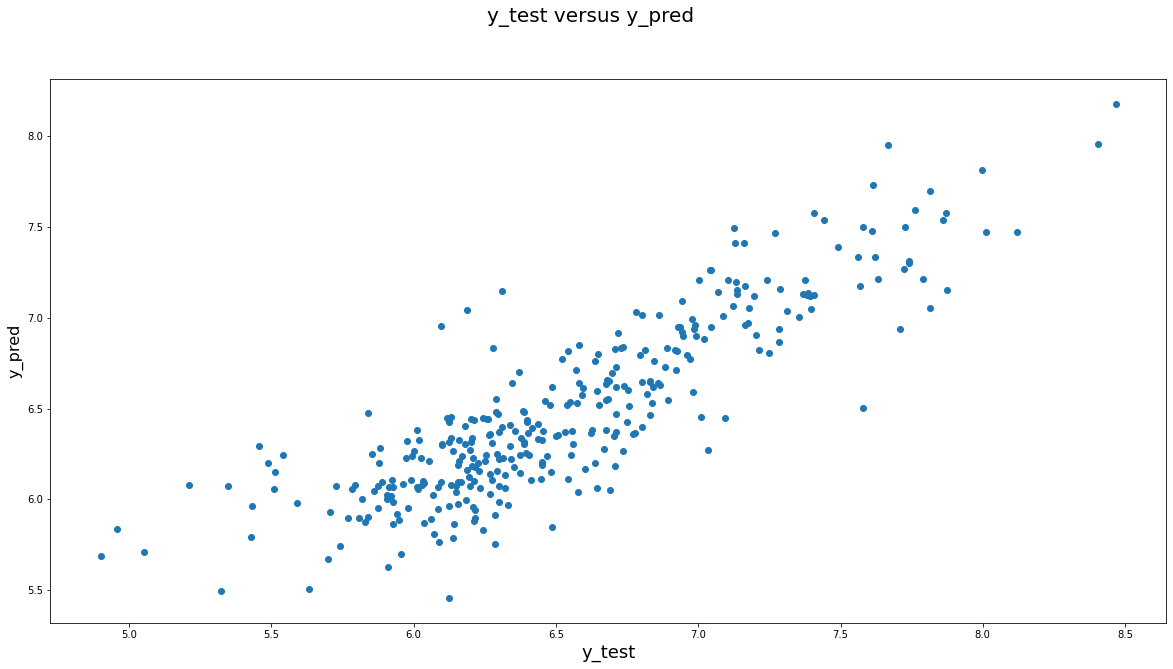

In [700]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,Ridge,ridge_params_best,df_resultats_bp,
                                     'Ridge_bp',tableau=True)

#### LASSO Optimisé

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .............alpha=0.02, tol=0.001;, score=0.524 total time=   0.0s
[CV 2/5] END .............alpha=0.02, tol=0.001;, score=0.605 total time=   0.0s
[CV 3/5] END .............alpha=0.02, tol=0.001;, score=0.580 total time=   0.0s
[CV 4/5] END .............alpha=0.02, tol=0.001;, score=0.553 total time=   0.0s
[CV 5/5] END .............alpha=0.02, tol=0.001;, score=0.584 total time=   0.0s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706


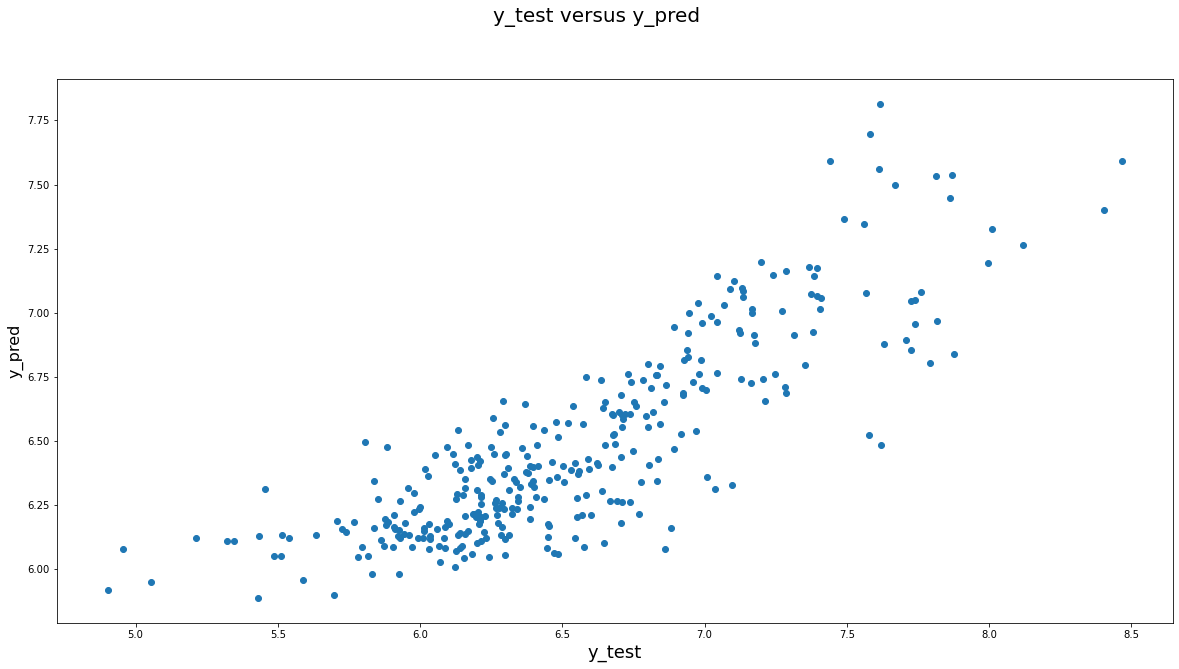

In [701]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,Lasso,lasso_params_best,df_resultats_bp,
                                     'Lasso_bp',tableau=True)

#### ElasticNet Optimisé

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.001, l1_ratio=0.3, tol=0.1;, score=0.654 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.3, tol=0.1;, score=0.724 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.3, tol=0.1;, score=0.738 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.3, tol=0.1;, score=0.725 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.3, tol=0.1;, score=0.689 total time=   0.0s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706
Elastic_bp,0.089925,0.747607,0.299874,96.488966,0.089760


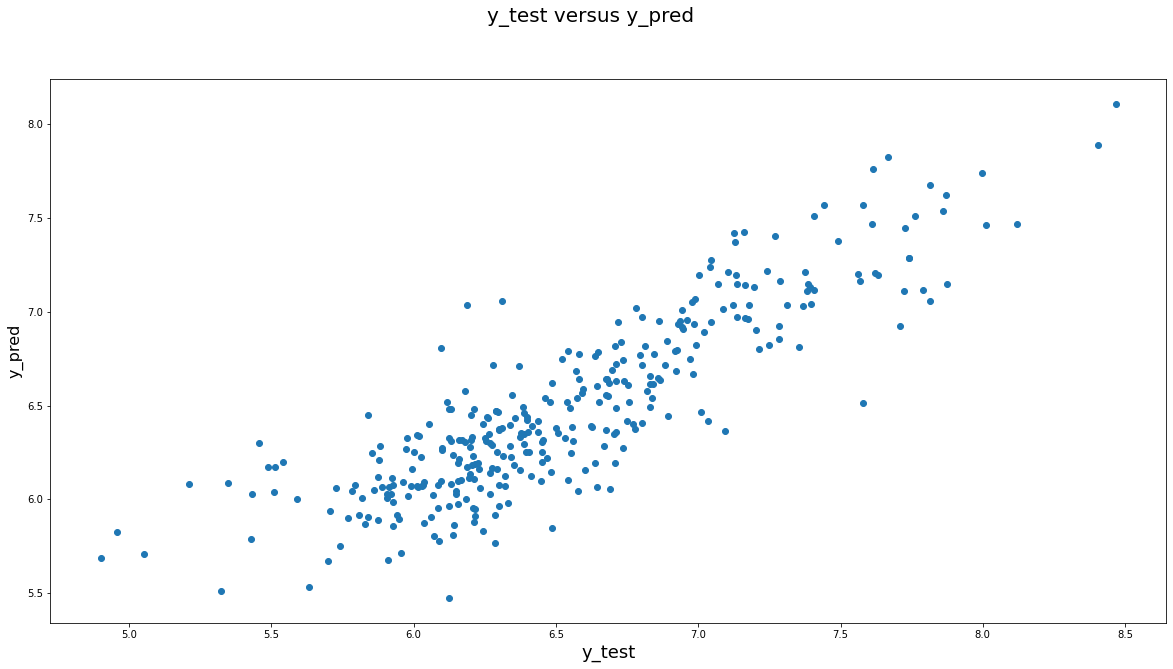

In [702]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,ElasticNet,elastic_params_best,
                                        df_resultats_bp,
                                     'Elastic_bp',tableau=True)

#### SVR Optimisé

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=1, epsilon=0.1, gamma=scale, tol=0.001;, score=0.604 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.1, gamma=scale, tol=0.001;, score=0.716 total time=   0.0s
[CV 3/5] END C=1, epsilon=0.1, gamma=scale, tol=0.001;, score=0.729 total time=   0.0s
[CV 4/5] END C=1, epsilon=0.1, gamma=scale, tol=0.001;, score=0.715 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.1, gamma=scale, tol=0.001;, score=0.682 total time=   0.0s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706
Elastic_bp,0.089925,0.747607,0.299874,96.488966,0.089760
SVR_bp,0.086600,0.756940,0.294278,96.589389,0.896004


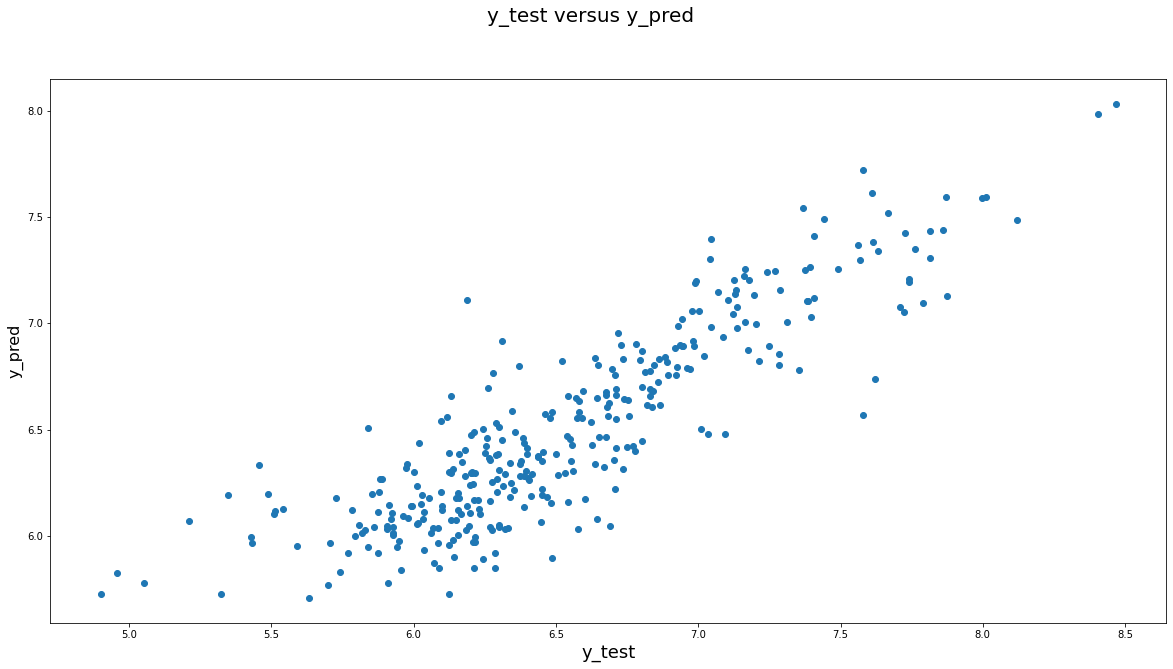

In [703]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,SVR,svr_params_best,df_resultats_bp,
                                        'SVR_bp',tableau=True)

#### KNR Optimisé

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .....................n_neighbors=8;, score=0.517 total time=   0.0s
[CV 2/5] END .....................n_neighbors=8;, score=0.559 total time=   0.0s
[CV 3/5] END .....................n_neighbors=8;, score=0.615 total time=   0.0s
[CV 4/5] END .....................n_neighbors=8;, score=0.514 total time=   0.0s
[CV 5/5] END .....................n_neighbors=8;, score=0.581 total time=   0.0s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706
Elastic_bp,0.089925,0.747607,0.299874,96.488966,0.089760
SVR_bp,0.086600,0.756940,0.294278,96.589389,0.896004
KNR_bp,0.139184,0.609351,0.373073,95.730200,0.128655


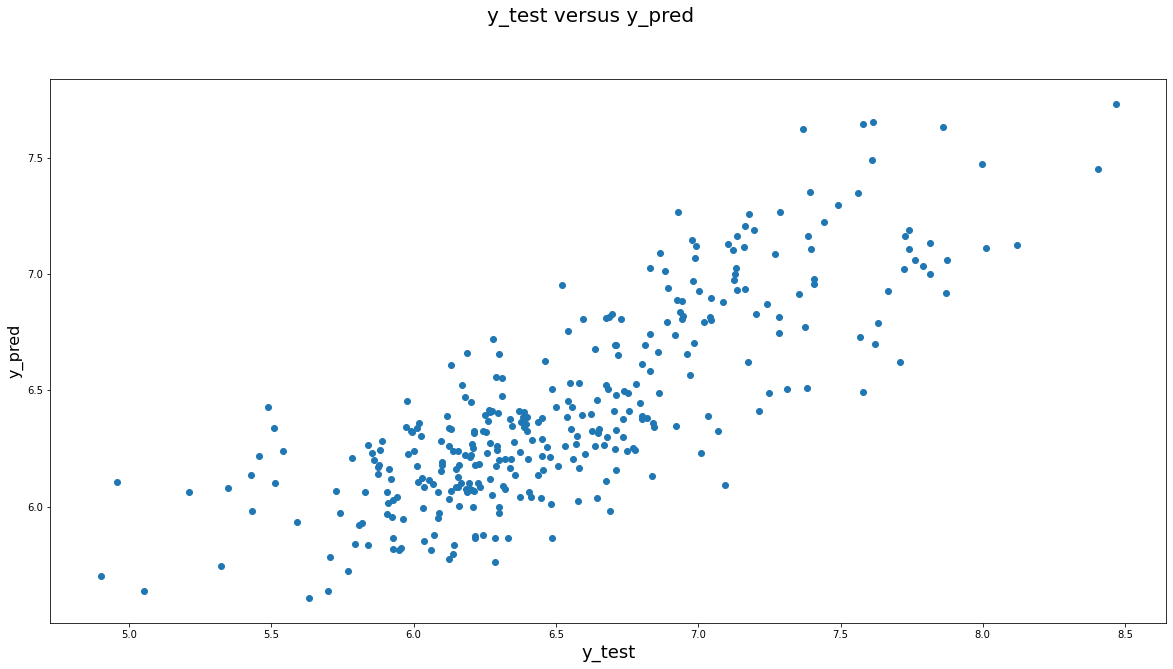

In [704]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,KNeighborsRegressor,knr_params_best,
                                        df_resultats_bp,
                                     'KNR_bp',tableau=True)

#### RFR  Optimisé

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.619 total time=   0.5s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.652 total time=   0.5s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.716 total time=   0.4s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.665 total time=   0.4s
[CV 5/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.672 total time=   0.4s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706
Elastic_bp,0.089925,0.747607,0.299874,96.488966,0.089760
SVR_bp,0.086600,0.756940,0.294278,96.589389,0.896004
KNR_bp,0.139184,0.609351,0.373073,95.730200,0.128655
RFR_bp,0.100473,0.718000,0.316975,96.404909,3.348817


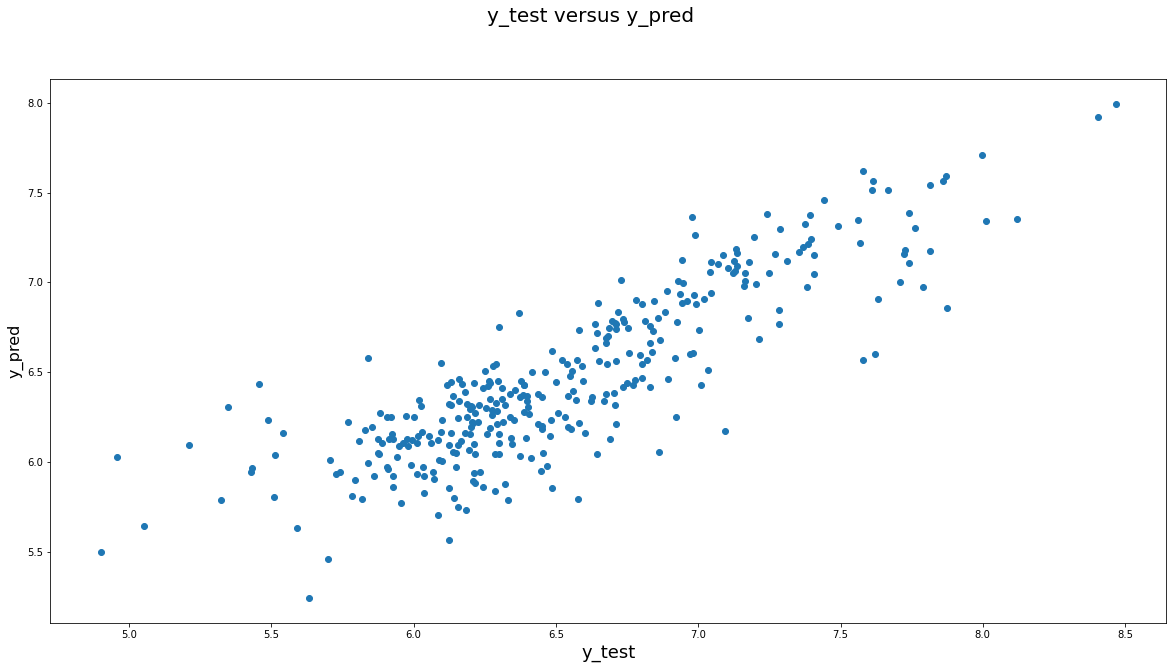

In [705]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,RandomForestRegressor,rfr_params_best,
                                        df_resultats_bp,
                                     'RFR_bp',tableau=True)

#### GBR OPTIMISE

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................n_estimators=200;, score=0.654 total time=   0.6s
[CV 2/5] END ..................n_estimators=200;, score=0.697 total time=   0.6s
[CV 3/5] END ..................n_estimators=200;, score=0.694 total time=   0.6s
[CV 4/5] END ..................n_estimators=200;, score=0.694 total time=   0.6s
[CV 5/5] END ..................n_estimators=200;, score=0.722 total time=   0.6s


Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706
Elastic_bp,0.089925,0.747607,0.299874,96.488966,0.089760
SVR_bp,0.086600,0.756940,0.294278,96.589389,0.896004
KNR_bp,0.139184,0.609351,0.373073,95.730200,0.128655
RFR_bp,0.100473,0.718000,0.316975,96.404909,3.348817
GBR_bp,0.086342,0.757663,0.293840,96.563710,4.297678


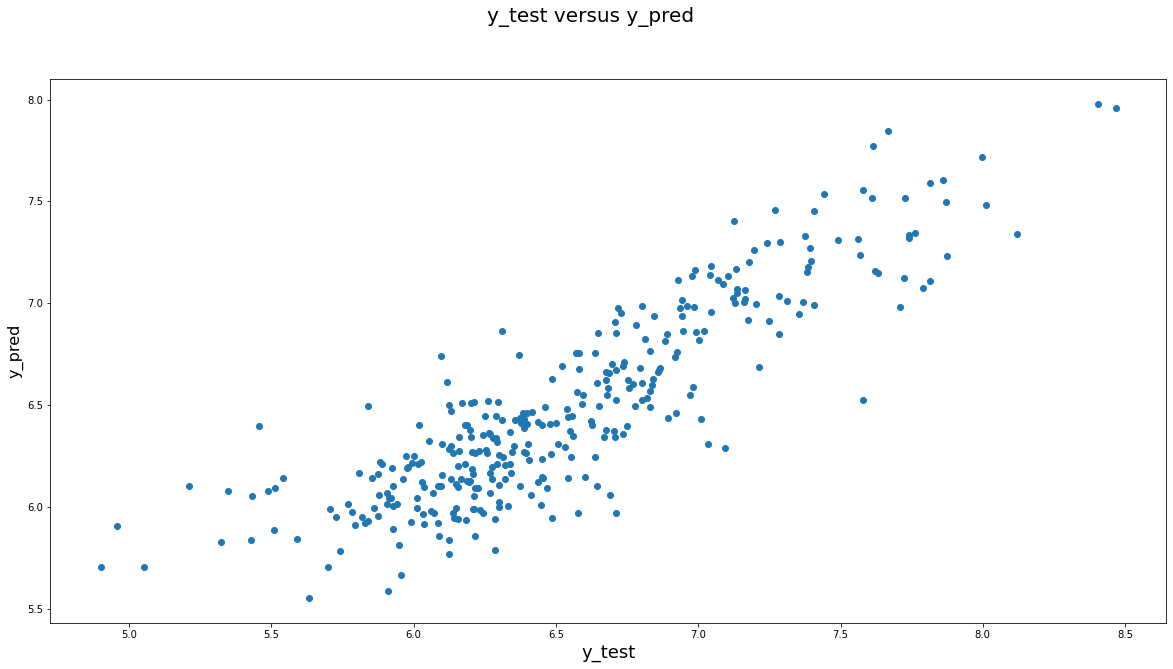

In [706]:
df_resultats_bp, y_pred=grid_regression(X_train,y_energy_train,X_test,y_energy_test,GradientBoostingRegressor,
                                        gradboost_params_best,df_resultats_bp,'GBR_bp',tableau=True)

## 3.3  Comparaison des performances 

In [707]:
comparatif = df_resultats_bp.sort_values(by=['Grid MSE','Grid RMSE','Grid R2'])
comparatif.style.hide_index()

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
GBR_bp,0.086342,0.757663,0.293840,96.563710,4.297678
SVR_bp,0.086600,0.756940,0.294278,96.589389,0.896004
Ridge_bp,0.089674,0.748311,0.299456,96.480618,0.077793
Elastic_bp,0.089925,0.747607,0.299874,96.488966,0.089760
RFR_bp,0.100473,0.718000,0.316975,96.404909,3.348817
Lasso_bp,0.122123,0.657236,0.349461,96.092682,0.085706
KNR_bp,0.139184,0.609351,0.373073,95.730200,0.128655


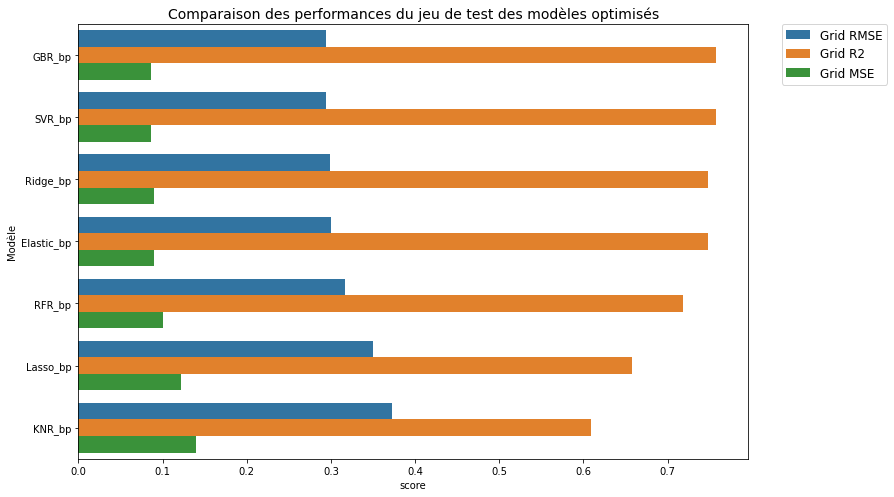

In [713]:
# comparaison sans la durée sur les critères 

df_compar = comparatif.head(7)
comparaison_score_melt = pd.melt(df_compar, id_vars=['Modèle'], value_name='score', value_vars=[
                                 'Grid RMSE', 'Grid R2','Grid MSE'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['score'],
            y=comparaison_score_melt['Modèle'], hue=comparaison_score_melt['variable'])
plt.title(
    'Comparaison des performances du jeu de test des modèles optimisés', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

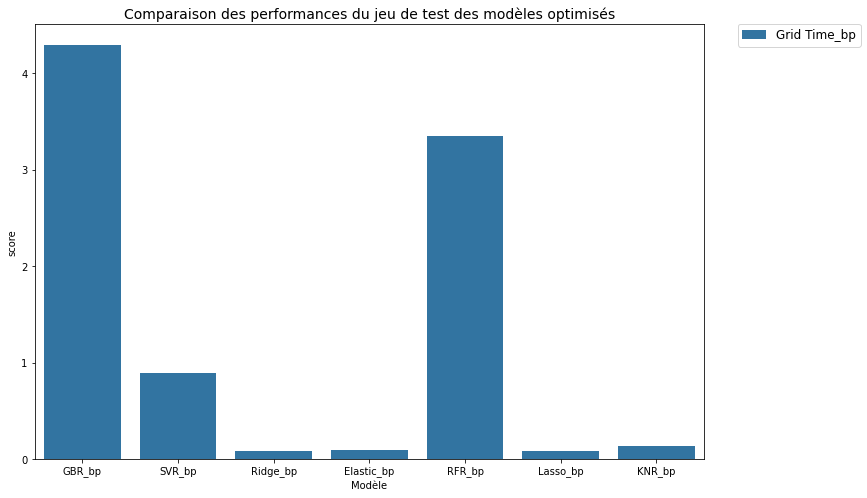

In [714]:
# comparatif durée
df_compar = comparatif.head(7)
comparaison_score_melt = pd.melt(df_compar, id_vars=['Modèle'], value_name='score', value_vars=[
                                 'Grid Time_bp'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'])
plt.title(
    'Comparaison des performances du jeu de test des modèles optimisés', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

In [725]:
# definition fonction learning curve (voir scikitlearn site)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training exemples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

   
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

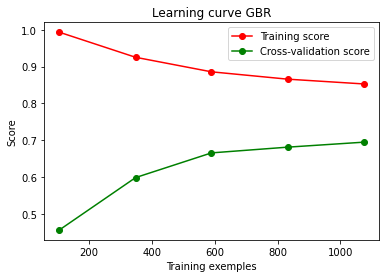

In [726]:
from sklearn.model_selection import learning_curve
estimator=GradientBoostingRegressor()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = gradboost_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train, y_energy_train)
plot_learning_curve(estimator_grid, 'Learning curve GBR',
                                 X_train, y_energy_train)

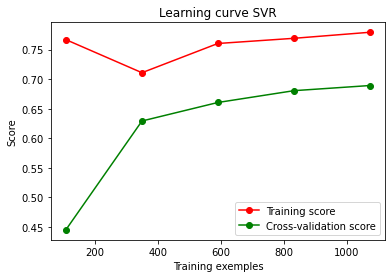

In [729]:
# learning curve SVR
estimator=SVR()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = svr_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train, y_energy_train)
plot_learning_curve(estimator_grid, 'Learning curve SVR',
                                 X_train, y_energy_train)

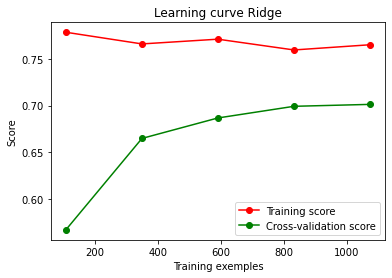

In [730]:
# Learning curve Ridge
estimator=Ridge()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = ridge_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train, y_energy_train)
plot_learning_curve(estimator_grid, 'Learning curve Ridge',
                                 X_train, y_energy_train)

## MODELES PERFORMANTS 

## 3.4 Pertinence des variables , exemple du modèle du modèle GBR

In [731]:
# Variables pertinentes pour la méthode GBR

In [732]:
estimator=GradientBoostingRegressor()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = gradboost_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train, y_energy_train)
   

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'n_estimators': [200]})

In [733]:
feature_importance=estimator.fit(X_train, y_energy_train).feature_importances_

In [734]:
# constitution d'un df des coeff et des variables

coefficients = feature_importance
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), 
                            axis = 1).sort_values(by='Coefficient',ascending=False)

In [735]:
liste_coefs_gbr

,Variable,Coefficient
9,log_propertygfabuilding,0.695407
34,x1_Supermarket / Grocery Store,0.042720
3,age,0.027024
36,x1_Warehouse,0.026546
61,x2_Non-Refrigerated Warehouse,0.021842
...,...,...
95,x3_Adult Education,0.000000
13,x0_Nonresidential WA,0.000000
23,x1_Mixed Use Property,0.000000
45,x2_Financial Office,0.000000


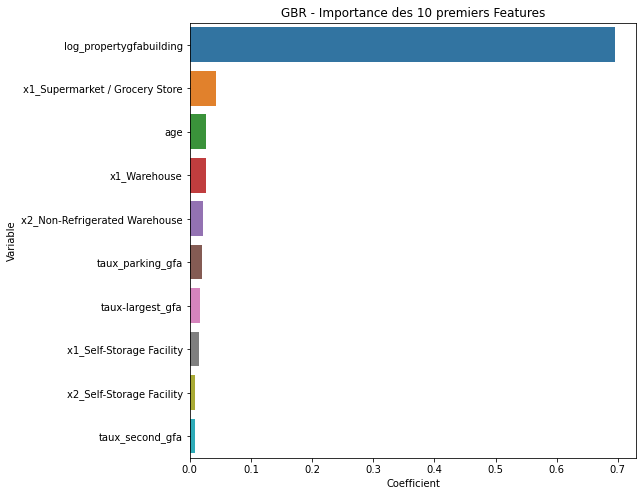

In [736]:
# visualisation des variables pertinentes
plt.figure(figsize=(8,8))
plt.title('GBR - Importance des 10 premiers Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(10),
            x = liste_coefs_gbr['Coefficient'].head(10))
plt.show()

In [737]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator_grid, random_state=1).fit(X_train, y_energy_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.9679 ± 0.0940,log_propertygfabuilding
0.0821 ± 0.0031,x1_Supermarket / Grocery Store
0.0444 ± 0.0014,age
0.0373 ± 0.0038,taux-largest_gfa
0.0345 ± 0.0074,x2_Non-Refrigerated Warehouse
0.0222 ± 0.0031,taux_parking_gfa
0.0160 ± 0.0051,x2_Self-Storage Facility
0.0140 ± 0.0013,x1_Warehouse
0.0117 ± 0.0023,x1_Other
0.0111 ± 0.0018,x2_Restaurant


#  TARGET EMISSIONS

## 4.1 Modélisation sans optimisation des hyperparamètres

In [738]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_resultats = pd.DataFrame(dtype='object')

In [739]:
# création d'une fonction de regression 

def process_regression(model_reg,X_train,X_test,y_train, y_test,df_resultats,titre,tableau=True):

    # Top début d'exécution
    time_start = time.time()

    # Entraînement du modèle
    model_reg.fit(X_train, y_train)
        
    # Prédictions avec le test set
    y_pred = model_reg.predict(X_test)

    # Top fin d'exécution
    time_end = time.time()

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape

    # durée d'exécution
    time_execution = time_end - time_start

    # cross validation
    scoring = ['r2', 'neg_mean_squared_error']
    scores = cross_validate(model_reg, X_train, y_train, cv=5,
                            scoring=scoring, return_train_score=True)

    # Sauvegarde des performances
    df_resultats = df_resultats.append(pd.DataFrame({
         'Modèle': [titre],
         'R2': [r2],
         'MSE': [mse],
         'RMSE': [rmse],
         'MAE': [mae],
         'Accuracy': [accuracy],
         'Time': [time_execution]
     }), ignore_index=True)

    if  tableau:
        display(df_resultats.style.hide_index())

   

    return df_resultats, y_pred


In [740]:
# Régression linéaire non régularisée
df_resultats, y_pred=process_regression(LinearRegression(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'LinearRegression',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822


In [741]:
# Régression linéaire régularisé RIDGE
df_resultats, y_pred=process_regression(Ridge(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'Ridge',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958


In [742]:
# Régression linéaire non régulariséE lASSO
df_resultats, y_pred=process_regression(Lasso(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'Lasso',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939


In [743]:
# Régression linéaire non régularisé ELASTICNET
df_resultats, y_pred=process_regression(ElasticNet(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'ElasticNet',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939
ElasticNet,-0.010397,0.414349,0.643699,0.496652,63.332176,0.011969


In [744]:
# SVR - Support Vector Regressor kernel non lineaire
df_resultats, y_pred=process_regression(SVR(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'SVR',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939
ElasticNet,-0.010397,0.414349,0.643699,0.496652,63.332176,0.011969
SVR,0.557084,0.181633,0.426185,0.323302,75.147990,0.265722


In [745]:
# KNR - KNeighborsRegressor
df_resultats, y_pred=process_regression(KNeighborsRegressor(), X_train, X_test, y_energy_train,
                                        y_energy_test,df_resultats,'KNeighborsRegressor',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939
ElasticNet,-0.010397,0.414349,0.643699,0.496652,63.332176,0.011969
SVR,0.557084,0.181633,0.426185,0.323302,75.147990,0.265722
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.028923


In [746]:
# RFR -RandomForestRegressor
df_resultats, y_pred=process_regression(RandomForestRegressor(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'RandomForestRegressor',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939
ElasticNet,-0.010397,0.414349,0.643699,0.496652,63.332176,0.011969
SVR,0.557084,0.181633,0.426185,0.323302,75.147990,0.265722
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.028923
RandomForestRegressor,0.541203,0.188146,0.433758,0.344908,74.506914,1.404035


In [747]:
# GBR -GradientBoostingRegressor()
df_resultats, y_pred=process_regression(GradientBoostingRegressor(), X_train, X_test, y_emission_train,
                                        y_emission_test,df_resultats,'GradientBoostingRegressor',tableau=True)

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939
ElasticNet,-0.010397,0.414349,0.643699,0.496652,63.332176,0.011969
SVR,0.557084,0.181633,0.426185,0.323302,75.147990,0.265722
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.028923
RandomForestRegressor,0.541203,0.188146,0.433758,0.344908,74.506914,1.404035
GradientBoostingRegressor,0.563364,0.179058,0.423152,0.340799,74.908869,0.481987


###  Bilan

In [748]:
# Comparaison des modèles à travers les métriques choisies

comparatif = df_resultats.sort_values(by=['RMSE', 'R2', 'Time'])
comparatif.style.hide_index()

Modèle,R2,MSE,RMSE,MAE,Accuracy,Time
KNeighborsRegressor,0.616954,0.136475,0.369425,0.280023,95.738052,0.028923
GradientBoostingRegressor,0.563364,0.179058,0.423152,0.340799,74.908869,0.481987
SVR,0.557084,0.181633,0.426185,0.323302,75.147990,0.265722
RandomForestRegressor,0.541203,0.188146,0.433758,0.344908,74.506914,1.404035
Ridge,0.518791,0.197337,0.444226,0.346014,74.500446,0.015958
ElasticNet,-0.010397,0.414349,0.643699,0.496652,63.332176,0.011969
Lasso,-0.010397,0.414349,0.643699,0.496652,63.332176,0.021939
LinearRegression,-3465316229650155307008.000000,1421076111348515471360.000000,37697163173.752419,4199569627.367992,-263676343113.903992,0.064822


In [749]:
# Comparaison visuelle des 3 algorithmes les plus performants
df_compar = comparatif.head(7)
comparaison_score_melt = pd.melt(df_compar, id_vars=['Modèle'], value_name='score', value_vars=[
                                 'MSE', 'R2', 'RMSE', 'Time'])

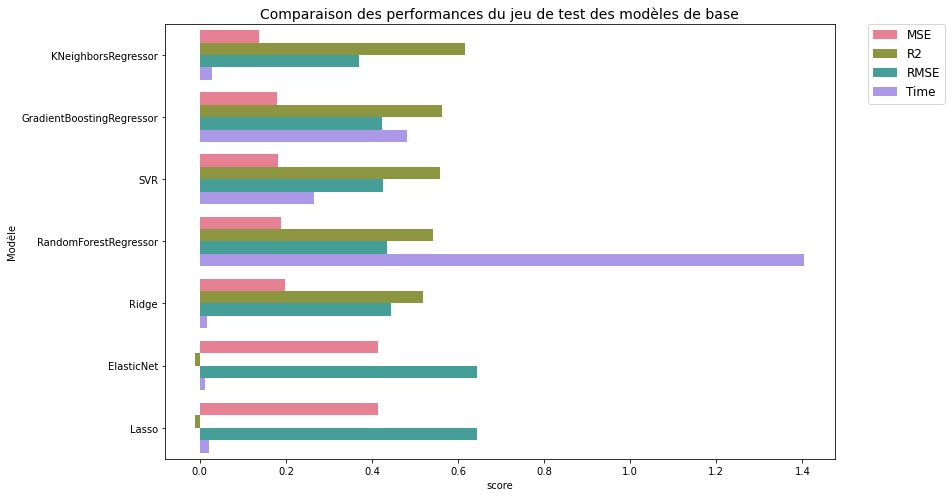

In [750]:
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['score'],
            y=comparaison_score_melt['Modèle'], hue=comparaison_score_melt['variable'],palette='husl')
plt.title(
    'Comparaison des performances du jeu de test des modèles de base', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

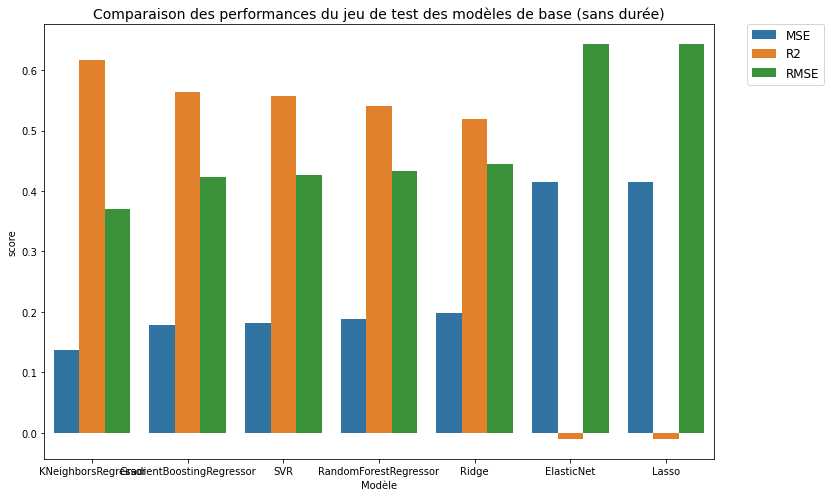

In [751]:
# Comparaison visuelle des algorithmes  sans la durée
comparaison_score_melt = pd.melt(df_compar, id_vars=[ 'Modèle'], value_name='score', value_vars=['MSE', 'R2', 'RMSE'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'])
plt.title(
    'Comparaison des performances du jeu de test des modèles de base (sans durée)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

## 4.2 Modélisation avec optimisation des hyperparamètres¶

In [775]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_resultats = pd.DataFrame(dtype='object')

In [776]:
# constitution d'un grid des hyperparamètres
ridge_params = {'alpha':[1,0.1,0.01,0.001], 'tol':[0.001]}

lasso_params={'alpha':[0.02, 0.024, 0.025, 0.026, 0.03], 'tol':[0.001]}

elastic_params={'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}

svr_params = {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10],'tol':[0.001]}

knr_params= {'n_neighbors':[3,4,5,6,7,8,9,10,20,30,50]}

rfr_params={'n_estimators' : [10,50,100,300,500],'min_samples_leaf' : [1,3,5,10],'max_features': ['auto', 'sqrt'] }

gradboost_params = {'n_estimators':[10,50,100, 200, 500]}


In [777]:
# création d'une fonction renvoyant les résultats best_param sur la base des grids choisies

def grid_regression(X_train,y_train,X_test,y_test,estimator, grid,df_resultats,titre,tableau=True):
      
    estimator_grid_emission = GridSearchCV(estimator = estimator(), 
                      param_grid = grid,cv=5,verbose=5)
    
    time_start = time.time()
    
    estimator_grid_emission.fit(X_train, y_train)
   
    
    # Prédictions avec le test set
    y_pred =  estimator_grid_emission.predict(X_test)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Calcul des métriques
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Sauvegarde des performances
    
    df_resultats = df_resultats.append(pd.DataFrame({
         'Modèle': [titre],
          'Best_param':[estimator_grid_emission.best_params_],
        'Best_scor':[estimator_grid_emission.best_score_],
         'Grid R2': [r2],
         'Grid RMSE': [rmse],
         'Grid MAE': [mae],
         'Grid Accuracy': [accuracy],
         'Grid Time': [time_execution]
     }), ignore_index=True)
    
    if tableau:
        display(df_resultats.style.hide_index())
        
    return df_resultats, y_pred   


#### RIDGE 

In [778]:
df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,Ridge,ridge_params,df_resultats,
                                     'Ridge',tableau=True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................alpha=1, tol=0.001;, score=0.457 total time=   0.0s
[CV 2/5] END ................alpha=1, tol=0.001;, score=0.523 total time=   0.0s
[CV 3/5] END ................alpha=1, tol=0.001;, score=0.576 total time=   0.0s
[CV 4/5] END ................alpha=1, tol=0.001;, score=0.451 total time=   0.0s
[CV 5/5] END ................alpha=1, tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END ..............alpha=0.1, tol=0.001;, score=0.446 total time=   0.0s
[CV 2/5] END ..............alpha=0.1, tol=0.001;, score=0.429 total time=   0.0s
[CV 3/5] END ..............alpha=0.1, tol=0.001;, score=0.525 total time=   0.0s
[CV 4/5] END ..............alpha=0.1, tol=0.001;, score=0.404 total time=   0.0s
[CV 5/5] END ..............alpha=0.1, tol=0.001;, score=0.479 total time=   0.0s
[CV 1/5] END .............alpha=0.01, tol=0.001;, score=0.443 total time=   0.0s
[CV 2/5] END .............alpha=0.01, tol=0.001;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688


#### Lasso

In [779]:
df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,Lasso,lasso_params,df_resultats,
                                     'lasso',tableau=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............alpha=0.02, tol=0.001;, score=0.318 total time=   0.0s
[CV 2/5] END .............alpha=0.02, tol=0.001;, score=0.425 total time=   0.0s
[CV 3/5] END .............alpha=0.02, tol=0.001;, score=0.435 total time=   0.0s
[CV 4/5] END .............alpha=0.02, tol=0.001;, score=0.359 total time=   0.0s
[CV 5/5] END .............alpha=0.02, tol=0.001;, score=0.448 total time=   0.0s
[CV 1/5] END ............alpha=0.024, tol=0.001;, score=0.313 total time=   0.0s
[CV 2/5] END ............alpha=0.024, tol=0.001;, score=0.416 total time=   0.0s
[CV 3/5] END ............alpha=0.024, tol=0.001;, score=0.423 total time=   0.0s
[CV 4/5] END ............alpha=0.024, tol=0.001;, score=0.346 total time=   0.0s
[CV 5/5] END ............alpha=0.024, tol=0.001;, score=0.436 total time=   0.0s
[CV 1/5] END ............alpha=0.025, tol=0.001;, score=0.312 total time=   0.0s
[CV 2/5] END ............alpha=0.025, tol=0.001;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688
lasso,"{'alpha': 0.02, 'tol': 0.001}",0.396948,0.501682,0.452054,0.357593,73.196648,0.345628


#### ElasticNet

In [780]:
df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,ElasticNet,elastic_params,
                                        df_resultats,
                                     'Elastic',tableau=True)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.446 total time=   0.1s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.25383865743181, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.40871907673316, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.431 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.527 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.55007607534512, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.57301433065938, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.404 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.1;, score=0.480 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.61607994651222, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.25383865743181, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.446 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.431 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.40871907673316, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.55007607534512, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.404 total time=   0.1s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.57301433065938, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.61607994651222, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.01;, score=0.480 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.446 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.25383865743181, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.40871907673316, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.431 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.527 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.55007607534512, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.57301433065938, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.404 total time=   0.1s
[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.001;, score=0.480 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.61607994651222, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.25383865743181, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.446 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.431 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.40871907673316, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.55007607534512, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.404 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.57301433065938, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.61607994651222, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.0, tol=0.0001;, score=0.480 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.446 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.430 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.406 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.1, tol=0.1;, score=0.482 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.447 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.430 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.405 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.1, tol=0.01;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.001;, score=0.447 total time=   0.0s
[CV 2/

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26886351593324775, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13150475750339297, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.1, tol=0.0001;, score=0.447 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.1, tol=0.0001;, score=0.430 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12568401296840648, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18248396384200305, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.1, tol=0.0001;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.1, tol=0.0001;, score=0.405 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.1, tol=0.0001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.2, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.2, tol=0.1;, score=0.429 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.2, tol=0.1;, score=0.528 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.2, tol=0.1;, score=0.409 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.2, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.2, tol=0.01;, score=0.448 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.2, tol=0.01;, score=0.429 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.2, tol=0.01;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.2, tol=0.01;, score=0.406 total time=   0.0s
[CV

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13866876408624762, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1301171373852128, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.2, tol=0.0001;, score=0.448 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.2, tol=0.0001;, score=0.429 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04859350244734628, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1330321025847354, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.2, tol=0.0001;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.2, tol=0.0001;, score=0.406 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.2, tol=0.0001;, score=0.482 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.1;, score=0.427 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.1;, score=0.528 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.1;, score=0.414 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.01;, score=0.448 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.01;, score=0.427 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.30000000000000004, 

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11816272473197387, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0652570721998984, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001;, score=0.427 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001;, score=0.527 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049076788227552015, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0876635088233968, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.30000000000000004, tol=0.0001;, score=0.482 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.4, tol=0.1;, score=0.444 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.4, tol=0.1;, score=0.425 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.4, tol=0.1;, score=0.528 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.4, tol=0.1;, score=0.417 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.4, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.4, tol=0.01;, score=0.448 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.4, tol=0.01;, score=0.425 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.4, tol=0.01;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.4, tol=0.01;, score=0.410 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.4, tol=0.01;, scor

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11792192796607992, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04996438223039945, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.4, tol=0.0001;, score=0.449 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.4, tol=0.0001;, score=0.425 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057908438744902924, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08476545104832667, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.4, tol=0.0001;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.4, tol=0.0001;, score=0.409 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.4, tol=0.0001;, score=0.482 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.5, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.5, tol=0.1;, score=0.422 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.5, tol=0.1;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.5, tol=0.1;, score=0.419 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.5, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.5, tol=0.01;, score=0.448 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.5, tol=0.01;, score=0.423 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.5, tol=0.01;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.5, tol=0.01;, score=0.412 total time=   0.0s
[CV

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12470418011412221, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05767667198691129, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.423 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.526 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07109726945546413, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09661492634867841, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.411 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.5, tol=0.0001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.444 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.420 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.527 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.422 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.01;, score=0.448 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.01;, score=0.421 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.01;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.6000000000000

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13030919050339662, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07825957295901276, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.421 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.526 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08061633823507464, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10204703703237783, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.413 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.417 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.425 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01;, score=0.449 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01;, score=0.419 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.01;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1289895735808102, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06095386573036876, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001;, score=0.450 total time=   0.1s
[CV 2/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001;, score=0.419 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08506455020673798, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10213858881044757, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001;, score=0.415 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.7000000000000001, tol=0.0001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.8, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.8, tol=0.1;, score=0.413 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.8, tol=0.1;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.8, tol=0.1;, score=0.428 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.8, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.8, tol=0.01;, score=0.449 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.8, tol=0.01;, score=0.416 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.8, tol=0.01;, score=0.524 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.8, 

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11192337153181597, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.8, tol=0.0001;, score=0.416 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.8, tol=0.0001;, score=0.524 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07818483506926555, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08972540202202595, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.8, tol=0.0001;, score=0.417 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.8, tol=0.0001;, score=0.480 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.9, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.9, tol=0.1;, score=0.410 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.9, tol=0.1;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.9, tol=0.1;, score=0.432 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.9, tol=0.1;, score=0.484 total time=   0.0s
[CV 1/5] END alpha=0.0001, l1_ratio=0.9, tol=0.01;, score=0.449 total time=   0.0s
[CV 2/5] END alpha=0.0001, l1_ratio=0.9, tol=0.01;, score=0.414 total time=   0.0s
[CV 3/5] END alpha=0.0001, l1_ratio=0.9, tol=0.01;, score=0.523 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.9, tol=0.01;, score=0.421 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.9, tol=0.01;, score=0.480 total time=   0.0s
[CV 1

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07123272574187922, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05179216529691644, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.9, tol=0.0001;, score=0.523 total time=   0.0s
[CV 4/5] END alpha=0.0001, l1_ratio=0.9, tol=0.0001;, score=0.420 total time=   0.0s
[CV 5/5] END alpha=0.0001, l1_ratio=0.9, tol=0.0001;, score=0.480 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057050516306503596, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.62166945205725, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.457 total time=   0.1s
[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.526 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.99681574298282, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.65268345406167, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.577 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.453 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.7437904650424, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.0656664241603, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.1;, score=0.518 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.457 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.62166945205725, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.99681574298282, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.526 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.577 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.65268345406167, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.7437904650424, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.453 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.01;, score=0.518 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.0656664241603, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.62166945205725, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.457 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.526 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.99681574298282, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.65268345406167, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.577 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.453 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.7437904650424, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.0656664241603, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.001;, score=0.518 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.457 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.62166945205725, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.99681574298282, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.526 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.577 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.65268345406167, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.7437904650424, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.453 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.0, tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.458 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.527 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.581 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.461 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.1, tol=0.1;, score=0.524 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.458 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.0656664241603, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.526 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.581 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.458 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.1, tol=0.01;, score=0.521 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.001;, score=0.458 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.1, tol=0.001;, score=0.527 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.1, tol=0.001;, score=0.581 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.1, tol=0.001;, score=0.458 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.1, tol=0.001;, score=0.520 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.1, tol=0.0001;, score=0.458 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.1, tol=0.0001;, score=0.527 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.1, tol=0.0001;, score=0.581 total time=   0.0s
[CV 4

[CV 4/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.001;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.001;, score=0.525 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.459 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.535 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.592 total time=   0.0s
[CV 4/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.001, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.525 total time=   0.0s
[CV 1/5] END alpha=0.001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.458 total time=   0.0s
[CV 2/5] END alpha=0.001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.538 total time=   0.0s
[CV 3/5] END alpha=0.001, l1_ratio=0.7000000000000001, tol=0.1;, score=0.593 total time=   0.0s
[CV 4/5] END alpha=0.

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.8532024882484, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.3950409314217, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.445 total time=   0.0s
[CV 2/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.543 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.14732479259169, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.22620293594417, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.585 total time=   0.0s
[CV 4/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.483 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.92442458578037, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.8532024882484, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .alpha=0.01, l1_ratio=0.0, tol=0.1;, score=0.545 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.445 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.3950409314217, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.14732479259169, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.543 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.585 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.22620293594417, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.92442458578037, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.483 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.0, tol=0.01;, score=0.545 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.8532024882484, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.3950409314217, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.445 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.543 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.14732479259169, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.22620293594417, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.585 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.483 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.92442458578037, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.8532024882484, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.01, l1_ratio=0.0, tol=0.001;, score=0.545 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.445 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.3950409314217, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.14732479259169, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.543 total time=   0.1s
[CV 3/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.585 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.22620293594417, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.92442458578037, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.483 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.0, tol=0.0001;, score=0.545 total time=   0.0s
[CV 1/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.433 total time=   0.0s
[CV 2/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.537 total time=   0.0s
[CV 3/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.576 total time=   0.0s
[CV 4/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.478 total time=   0.0s
[CV 5/5] END .alpha=0.01, l1_ratio=0.1, tol=0.1;, score=0.539 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.431 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.536 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.576 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.478 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.1, tol=0.01;, score=0.539 total time=   0.0s
[CV 1/5] END alpha=0.01,

[CV 4/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.438 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.01;, score=0.508 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.369 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.518 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.437 total time=   0.0s
[CV 5/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.001;, score=0.507 total time=   0.0s
[CV 1/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.369 total time=   0.0s
[CV 2/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.6000000000000001, tol=0.0001;, score=0.517 total time=   0.0s
[CV 4/5] END alpha=0.01, l1_r

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.81024198316351, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.32247179892454, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.501 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.86780100815568, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.51838650620134, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.419 total time=   0.0s
[CV 5/5] END ..alpha=0.1, l1_ratio=0.0, tol=0.1;, score=0.502 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.90765833416927, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.81024198316351, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.331 total time=   0.1s
[CV 2/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.483 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.32247179892454, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.86780100815568, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.501 total time=   0.0s
[CV 4/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.419 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.51838650620134, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.90765833416927, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .alpha=0.1, l1_ratio=0.0, tol=0.01;, score=0.502 total time=   0.1s
[CV 1/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.331 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.81024198316351, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.32247179892454, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.501 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.86780100815568, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.51838650620134, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.419 total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.0, tol=0.001;, score=0.502 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.90765833416927, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.81024198316351, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.331 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.483 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.32247179892454, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.86780100815568, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.419 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.51838650620134, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.90765833416927, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.1, l1_ratio=0.0, tol=0.0001;, score=0.502 total time=   0.0s
[CV 1/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.250 total time=   0.0s
[CV 2/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.435 total time=   0.0s
[CV 3/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.434 total time=   0.0s
[CV 4/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.361 total time=   0.0s
[CV 5/5] END ..alpha=0.1, l1_ratio=0.1, tol=0.1;, score=0.462 total time=   0.0s
[CV 1/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.280 total time=   0.0s
[CV 2/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.435 total time=   0.0s
[CV 3/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.440 total time=   0.0s
[CV 4/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.367 total time=   0.0s
[CV 5/5] END .alpha=0.1, l1_ratio=0.1, tol=0.01;, score=0.459 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.1, tol=0.001;, score=0.281 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_

[CV 5/5] END alpha=0.1, l1_ratio=0.5, tol=0.0001;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.271 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.348 total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.271 total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.1;, score=0.363 total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.281 total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.342 total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.353 total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, score=0.276 total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.6000000000000001, tol=0.01;, scor

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.93699271975015, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.7578634811361, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.294 total time=   0.0s
[CV 3/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.291 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39278182848847, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.61348185726936, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.237 total time=   0.0s
[CV 5/5] END ....alpha=1, l1_ratio=0.0, tol=0.1;, score=0.332 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.35108316305667, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.93699271975015, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.178 total time=   0.0s
[CV 2/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.294 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.7578634811361, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39278182848847, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.291 total time=   0.0s
[CV 4/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.237 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.61348185726936, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.35108316305667, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ...alpha=1, l1_ratio=0.0, tol=0.01;, score=0.332 total time=   0.0s
[CV 1/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.178 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.93699271975015, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.7578634811361, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.294 total time=   0.0s
[CV 3/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.291 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39278182848847, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.61348185726936, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.237 total time=   0.0s
[CV 5/5] END ..alpha=1, l1_ratio=0.0, tol=0.001;, score=0.332 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.35108316305667, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.93699271975015, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.178 total time=   0.0s
[CV 2/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.294 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.7578634811361, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.39278182848847, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.291 total time=   0.0s
[CV 4/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.237 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.61348185726936, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.35108316305667, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .alpha=1, l1_ratio=0.0, tol=0.0001;, score=0.332 total time=   0.0s
[CV 1/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.174 total time=   0.0s
[CV 2/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.192 total time=   0.0s
[CV 3/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.198 total time=   0.0s
[CV 4/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.156 total time=   0.0s
[CV 5/5] END ....alpha=1, l1_ratio=0.1, tol=0.1;, score=0.220 total time=   0.0s
[CV 1/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.174 total time=   0.0s
[CV 2/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.192 total time=   0.0s
[CV 3/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.198 total time=   0.0s
[CV 4/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.156 total time=   0.0s
[CV 5/5] END ...alpha=1, l1_ratio=0.1, tol=0.01;, score=0.220 total time=   0.0s
[CV 1/5] END ..alpha=1, l1_ratio=0.1, tol=0.001;, score=0.174 total time=   0.0s
[CV 2/5] END ..alpha=1, l1_r

[CV 3/5] END alpha=1, l1_ratio=0.5, tol=0.0001;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.5, tol=0.0001;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.5, tol=0.0001;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.001 total time=   0.0s
[CV 4/5] E

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.10052519016367, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.42191897765346, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.104 total time=   0.0s
[CV 3/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.106 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.65338695118834, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.79551911610093, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.088 total time=   0.0s
[CV 5/5] END ...alpha=10, l1_ratio=0.0, tol=0.1;, score=0.127 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.05882924946604, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.10052519016367, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.104 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.42191897765346, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.65338695118834, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.106 total time=   0.0s
[CV 4/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.088 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.79551911610093, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.05882924946604, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..alpha=10, l1_ratio=0.0, tol=0.01;, score=0.127 total time=   0.0s
[CV 1/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.106 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.10052519016367, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.42191897765346, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.104 total time=   0.0s
[CV 3/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.106 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.65338695118834, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.79551911610093, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.088 total time=   0.1s
[CV 5/5] END .alpha=10, l1_ratio=0.0, tol=0.001;, score=0.127 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.05882924946604, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.10052519016367, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.104 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.42191897765346, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.65338695118834, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.106 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.088 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.79551911610093, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.05882924946604, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.0, tol=0.0001;, score=0.127 total time=   0.0s
[CV 1/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.014 total time=   0.0s
[CV 2/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.003 total time=   0.0s
[CV 3/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.001 total time=   0.0s
[CV 4/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.001 total time=   0.0s
[CV 5/5] END ..alpha=10, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.014 total time=   0.0s
[CV 2/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.003 total time=   0.0s
[CV 3/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.001 total time=   0.0s
[CV 4/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.001 total time=   0.0s
[CV 5/5] END .alpha=10, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.1, tol=0.001;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=10, l1_ra

[CV 4/5] END alpha=10, l1_ratio=0.5, tol=0.0001;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.5, tol=0.0001;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.001 total

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.91981228859512, tolerance: 42.74601833435548
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.41177889143964, tolerance: 44.134082063869386
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.005 total time=   0.0s
[CV 2/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.014 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.32541988886723, tolerance: 43.50553778224027
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.3665022354974, tolerance: 43.54564493494939
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.016 total time=   0.0s
[CV 4/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.013 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.19898813497124, tolerance: 42.81759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.91981228859512, tolerance: 4.274601833435549
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..alpha=100, l1_ratio=0.0, tol=0.1;, score=0.020 total time=   0.0s
[CV 1/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.005 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.41177889143964, tolerance: 4.413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.32541988886723, tolerance: 4.350553778224026
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.014 total time=   0.1s
[CV 3/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.016 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.3665022354974, tolerance: 4.354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.19898813497124, tolerance: 4.281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.013 total time=   0.1s
[CV 5/5] END .alpha=100, l1_ratio=0.0, tol=0.01;, score=0.020 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.91981228859512, tolerance: 0.42746018334355484
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.41177889143964, tolerance: 0.4413408206386938
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.005 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.014 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.32541988886723, tolerance: 0.43505537782240267
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.3665022354974, tolerance: 0.43545644934949385
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.016 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.013 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.19898813497124, tolerance: 0.4281759830694834
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.91981228859512, tolerance: 0.042746018334355484
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.0, tol=0.001;, score=0.020 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.005 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.41177889143964, tolerance: 0.04413408206386938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.32541988886723, tolerance: 0.04350553778224027
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.014 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.016 total time=   0.0s


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.3665022354974, tolerance: 0.04354564493494938
  model = cd_fast.enet_coordinate_descent(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.19898813497124, tolerance: 0.04281759830694834
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.013 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.0, tol=0.0001;, score=0.020 total time=   0.0s
[CV 1/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.014 total time=   0.0s
[CV 2/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.003 total time=   0.0s
[CV 3/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.001 total time=   0.0s
[CV 4/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.001 total time=   0.0s
[CV 5/5] END .alpha=100, l1_ratio=0.1, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.1, tol=0.01;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1

[CV 3/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.001 total time=   0.0s
[CV 4/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.01;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.001;, score=-0.014 total time=   0.0s
[CV 2/5] END alpha=100, l1_ratio=0.6000000000000001, tol=0.001;, score=-0.003 total time=   0.0s
[CV 3/5] END alpha=100, l1_ratio=0.600000

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688
lasso,"{'alpha': 0.02, 'tol': 0.001}",0.396948,0.501682,0.452054,0.357593,73.196648,0.345628
Elastic,"{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.1}",0.520882,0.531981,0.438096,0.347576,74.428043,41.948453


#### SVR

In [781]:
df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,SVR,svr_params,df_resultats,
                                     'SVR',tableau=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.037 total time=   0.1s
[CV 2/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.039 total time=   0.1s
[CV 3/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.041 total time=   0.1s
[CV 4/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.032 total time=   0.1s
[CV 5/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.045 total time=   0.1s
[CV 1/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.037 total time=   0.1s
[CV 2/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.039 total time=   0.1s
[CV 3/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.040 total time=   0.1s
[CV 4/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.032 total time=   0.1s
[CV 5/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.044 total time=   0.1s
[CV 1/5] END 

[CV 2/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.535 total time=   0.1s
[CV 3/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.547 total time=   0.1s
[CV 4/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.478 total time=   0.1s
[CV 5/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.475 total time=   0.1s
[CV 1/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.313 total time=   0.0s
[CV 2/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.345 total time=   0.0s
[CV 3/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.444 total time=   0.0s
[CV 4/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.315 total time=   0.0s
[CV 5/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.388 total time=   0.0s


Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688
lasso,"{'alpha': 0.02, 'tol': 0.001}",0.396948,0.501682,0.452054,0.357593,73.196648,0.345628
Elastic,"{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.1}",0.520882,0.531981,0.438096,0.347576,74.428043,41.948453
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.510773,0.557084,0.426185,0.323302,75.147990,13.845234


#### KNR

In [782]:

df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,KNeighborsRegressor,knr_params,
                                     df_resultats, 'KNR',tableau=True)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .....................n_neighbors=3;, score=0.285 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.348 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.402 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.247 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.393 total time=   0.0s
[CV 1/5] END .....................n_neighbors=4;, score=0.314 total time=   0.0s
[CV 2/5] END .....................n_neighbors=4;, score=0.370 total time=   0.0s
[CV 3/5] END .....................n_neighbors=4;, score=0.418 total time=   0.0s
[CV 4/5] END .....................n_neighbors=4;, score=0.279 total time=   0.0s
[CV 5/5] END .....................n_neighbors=4;, score=0.420 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.320 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688
lasso,"{'alpha': 0.02, 'tol': 0.001}",0.396948,0.501682,0.452054,0.357593,73.196648,0.345628
Elastic,"{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.1}",0.520882,0.531981,0.438096,0.347576,74.428043,41.948453
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.510773,0.557084,0.426185,0.323302,75.147990,13.845234
KNR,{'n_neighbors': 8},0.401573,0.442943,0.477955,0.370585,73.429800,0.992889


#### RFR

In [783]:
df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,RandomForestRegressor,rfr_params,
                                        df_resultats,
                                     'RFR',tableau=True)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.433 total time=   0.1s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.447 total time=   0.0s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.476 total time=   0.0s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.354 total time=   0.0s
[CV 5/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.462 total time=   0.0s
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.444 total time=   0.4s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.461 total time=   0.4s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.533 total time=   0.4s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.423 total time=   0.4s
[CV 5/5] END max_features=aut

[CV 2/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.414 total time=   0.2s
[CV 3/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.470 total time=   0.2s
[CV 4/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.420 total time=   0.2s
[CV 5/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.502 total time=   0.2s
[CV 1/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.402 total time=   0.4s
[CV 2/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.411 total time=   0.4s
[CV 3/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.471 total time=   0.4s
[CV 4/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.420 total time=   0.4s
[CV 5/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.502 total time=   0.4s
[CV 1/5] END max_features=auto, min_samples_leaf=10, n_estimators=300;, score

[CV 3/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.429 total time=   0.1s
[CV 4/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.356 total time=   0.1s
[CV 5/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.443 total time=   0.1s
[CV 1/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.356 total time=   0.7s
[CV 2/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.400 total time=   0.5s
[CV 3/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.435 total time=   0.4s
[CV 4/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.356 total time=   0.4s
[CV 5/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.454 total time=   0.4s
[CV 1/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.356 total time=   0.7s
[CV 2/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.402

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688
lasso,"{'alpha': 0.02, 'tol': 0.001}",0.396948,0.501682,0.452054,0.357593,73.196648,0.345628
Elastic,"{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.1}",0.520882,0.531981,0.438096,0.347576,74.428043,41.948453
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.510773,0.557084,0.426185,0.323302,75.147990,13.845234
KNR,{'n_neighbors': 8},0.401573,0.442943,0.477955,0.370585,73.429800,0.992889
RFR,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}",0.486013,0.535953,0.436233,0.337264,74.146718,175.110460


#### GBR

In [784]:
df_resultats, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,GradientBoostingRegressor,
                                     gradboost_params,
                                     df_resultats,'GBR',tableau=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................n_estimators=10;, score=0.306 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;, score=0.352 total time=   0.0s
[CV 3/5] END ...................n_estimators=10;, score=0.399 total time=   0.0s
[CV 4/5] END ...................n_estimators=10;, score=0.337 total time=   0.0s
[CV 5/5] END ...................n_estimators=10;, score=0.390 total time=   0.0s
[CV 1/5] END ...................n_estimators=50;, score=0.429 total time=   0.1s
[CV 2/5] END ...................n_estimators=50;, score=0.507 total time=   0.1s
[CV 3/5] END ...................n_estimators=50;, score=0.543 total time=   0.1s
[CV 4/5] END ...................n_estimators=50;, score=0.448 total time=   0.1s
[CV 5/5] END ...................n_estimators=50;, score=0.532 total time=   0.1s
[CV 1/5] END ..................n_estimators=100;, score=0.450 total time=   0.3s
[CV 2/5] END ..................n_estimators=100;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
Ridge,"{'alpha': 1, 'tol': 0.001}",0.504743,0.518791,0.444226,0.346014,74.500446,0.262688
lasso,"{'alpha': 0.02, 'tol': 0.001}",0.396948,0.501682,0.452054,0.357593,73.196648,0.345628
Elastic,"{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.1}",0.520882,0.531981,0.438096,0.347576,74.428043,41.948453
SVR,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.510773,0.557084,0.426185,0.323302,75.147990,13.845234
KNR,{'n_neighbors': 8},0.401573,0.442943,0.477955,0.370585,73.429800,0.992889
RFR,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}",0.486013,0.535953,0.436233,0.337264,74.146718,175.110460
GBR,{'n_estimators': 200},0.514429,0.557068,0.426193,0.341235,74.939759,16.258256


### Modélisation avec les best_param

In [984]:
# creation d'un fichier résultats best param
df_resultats_bp = pd.DataFrame(dtype='object')

In [985]:
# best_param de la section précedente

ridge_params_best = {'alpha':[1], 'tol':[0.001]}

lasso_params_best={'alpha':[0.02], 'tol':[0.001]}

elastic_params_best={'tol' : [0.01],
              "alpha": [0.001],
              "l1_ratio": [0.9]}

svr_params_best = {'gamma' : ['scale'],'epsilon' : [ 0.1], 
              'C' : [1.1],'tol':[0.01]}

knr_params_best= {'n_neighbors':[8]}

rfr_params_best={'n_estimators' : [100],'min_samples_leaf' : [3],'max_features': ['auto'] }

gradboost_params_best = {'n_estimators':[200]}



In [986]:
# Ajout de la visualisation dans la fonction 

def grid_regression(X_train,y_train,X_test,y_test,estimator, grid,df_resultats_bp,titre,tableau=True):
      
    estimator_grid_emission = GridSearchCV(estimator = estimator(), 
                      param_grid = grid,cv=5,verbose=0)
    
    time_start = time.time()
    
    # Predictions avec le train set
    estimator_grid_emission.fit(X_train, y_train)
   
    
    # Prédictions avec le test set
    y_pred =  estimator_grid_emission.predict(X_test)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Calcul des métriques
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    
    # Visualisation des prédictions / valeurs réélles du jeu de test 
    fig = plt.figure(figsize=(20, 10))
    plt.scatter(y_energy_test, y_pred)
    fig.suptitle('y_test versus y_pred', fontsize=20)
    plt.xlabel('y_test', fontsize=18)
    plt.ylabel('y_pred', fontsize=16)
    
    # Sauvegarde des performances
    
    df_resultats_bp= df_resultats_bp.append(pd.DataFrame({
         'Modèle': [titre],
        'Grid MSE':[mse],
         'Grid R2': [r2],
         'Grid RMSE': [rmse],
         'Grid Accuracy': [accuracy],
         'Grid Time_bp': [time_execution]
        }), ignore_index=True)
    
    if tableau:
        display(df_resultats_bp.style.hide_index())
        
    return df_resultats_bp, y_pred   

### Lasso Optimé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020


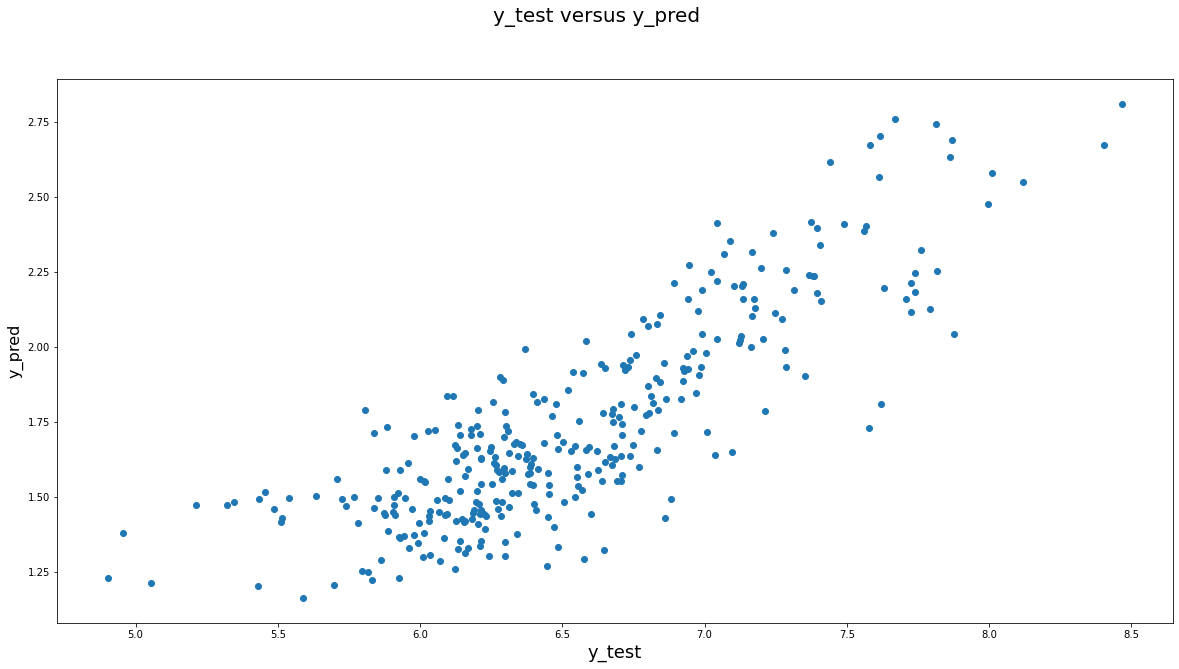

In [987]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,Lasso,lasso_params_best,
                                        df_resultats_bp,
                                     'lasso_bp',tableau=True)

### Ridge Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616


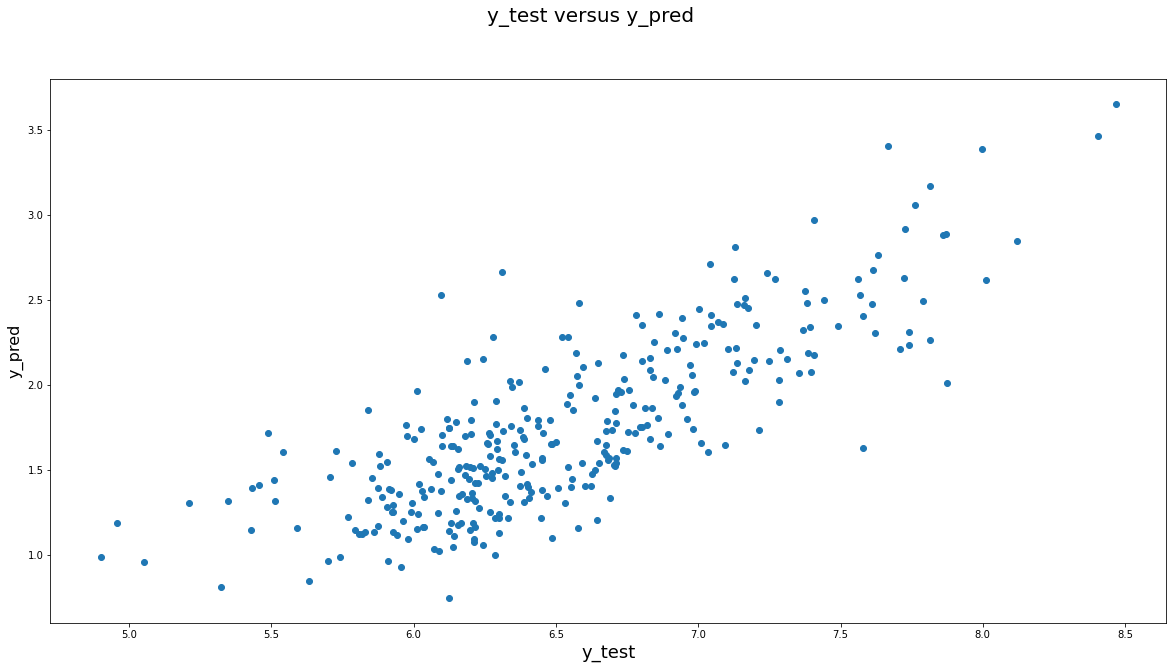

In [988]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,Ridge,ridge_params_best,
                                        df_resultats_bp,
                                     'RIDGE_bp',tableau=True)

### Elastic Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616
Elastic_bp,0.191489,0.533050,0.437595,74.428330,0.096740


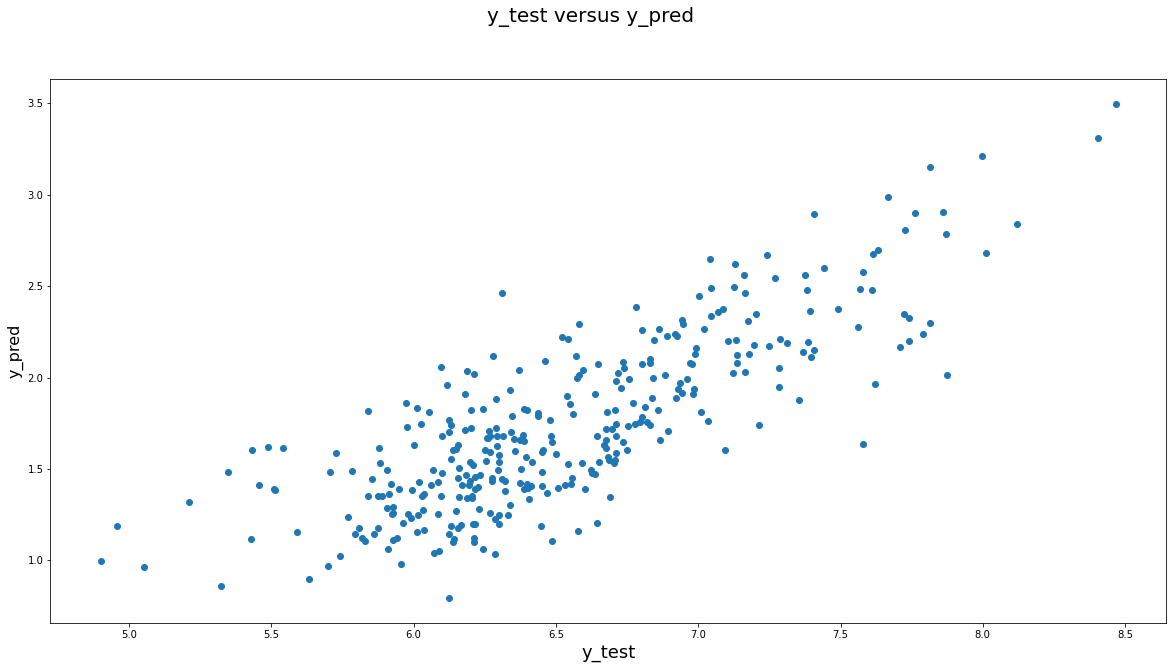

In [989]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,ElasticNet,elastic_params_best,
                                        df_resultats_bp,
                                     'Elastic_bp',tableau=True)

### RFR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616
Elastic_bp,0.191489,0.533050,0.437595,74.428330,0.096740
RFR_bp,0.185742,0.547066,0.430978,74.907760,4.879570


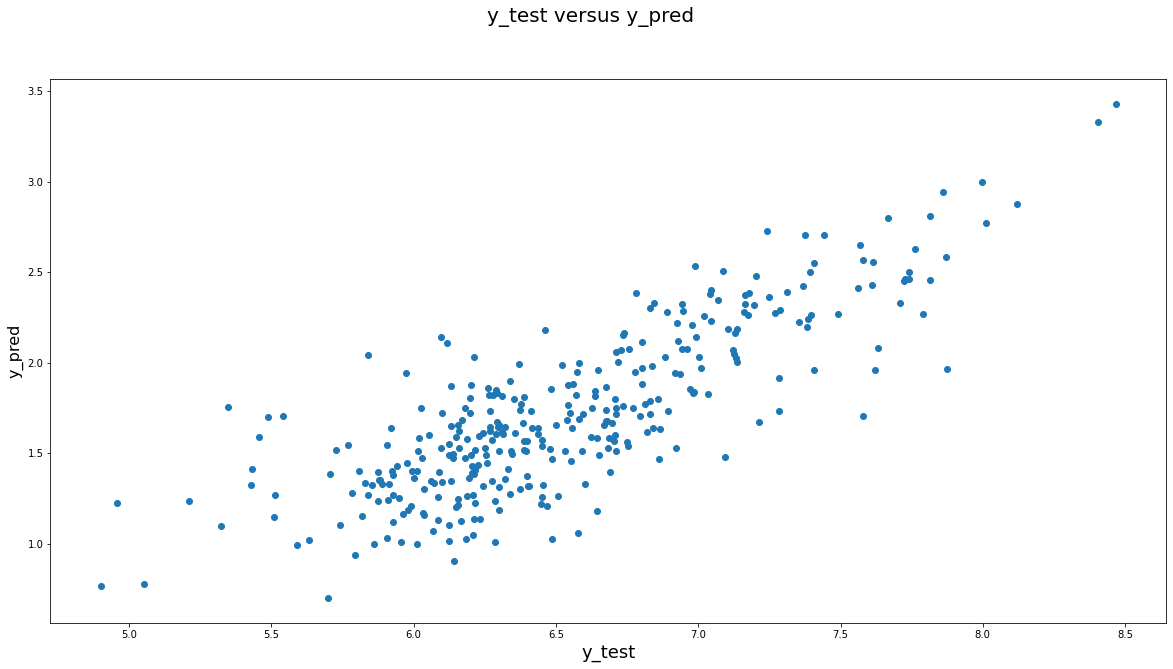

In [990]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,RandomForestRegressor,rfr_params_best,
                                        df_resultats_bp,
                                     'RFR_bp',tableau=True)

### KNR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616
Elastic_bp,0.191489,0.533050,0.437595,74.428330,0.096740
RFR_bp,0.185742,0.547066,0.430978,74.907760,4.879570
KNR_bp,0.228441,0.442943,0.477955,73.429800,0.115319


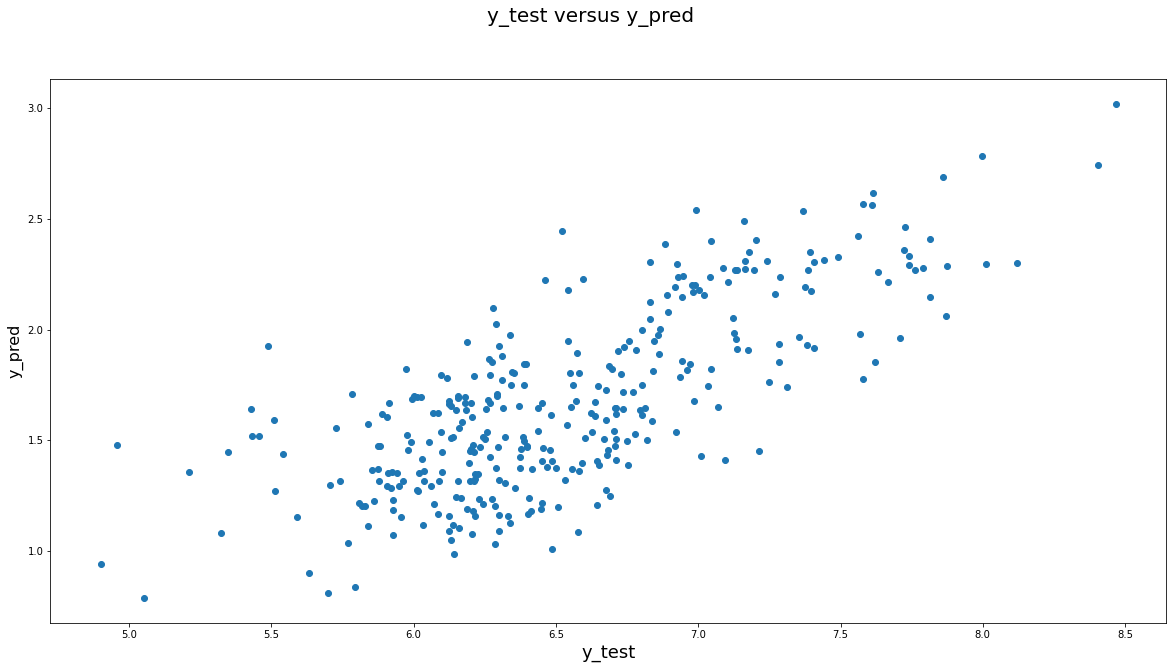

In [991]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,KNeighborsRegressor,knr_params_best,
                                        df_resultats_bp,
                                     'KNR_bp',tableau=True)

### SVR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616
Elastic_bp,0.191489,0.533050,0.437595,74.428330,0.096740
RFR_bp,0.185742,0.547066,0.430978,74.907760,4.879570
KNR_bp,0.228441,0.442943,0.477955,73.429800,0.115319
SVR_bp,0.181777,0.556734,0.426353,75.116087,0.958299


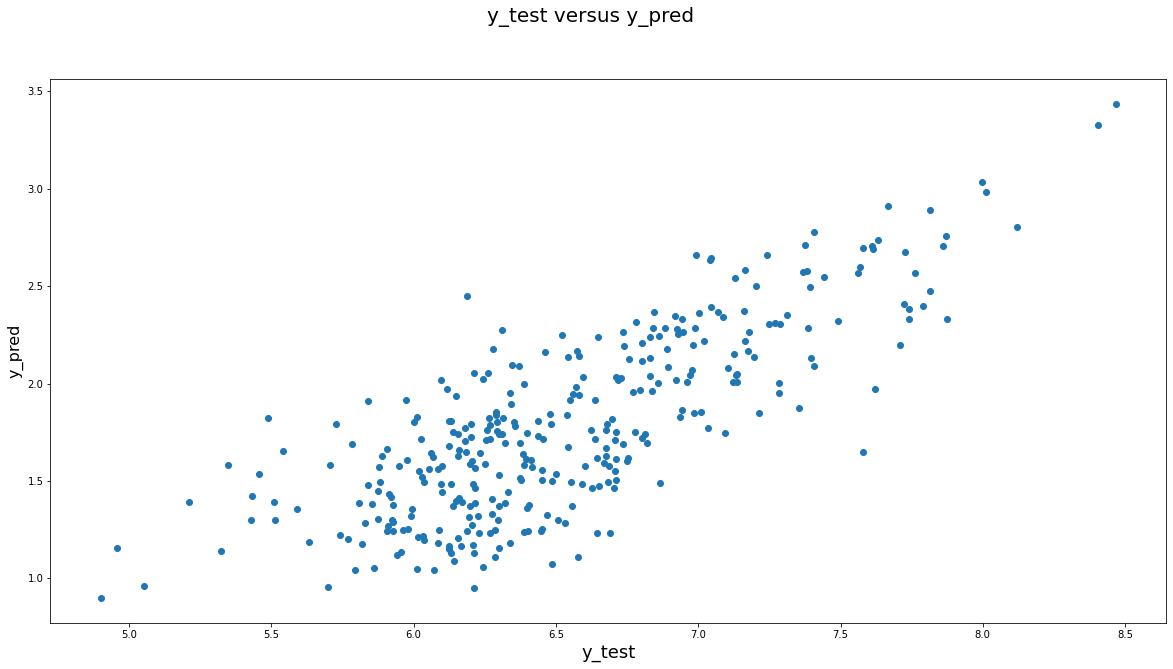

In [992]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,SVR,svr_params_best,df_resultats_bp,
                                     'SVR_bp', tableau=True)

### GBR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616
Elastic_bp,0.191489,0.533050,0.437595,74.428330,0.096740
RFR_bp,0.185742,0.547066,0.430978,74.907760,4.879570
KNR_bp,0.228441,0.442943,0.477955,73.429800,0.115319
SVR_bp,0.181777,0.556734,0.426353,75.116087,0.958299
GBR_bp,0.181596,0.557176,0.426140,74.956825,4.389760


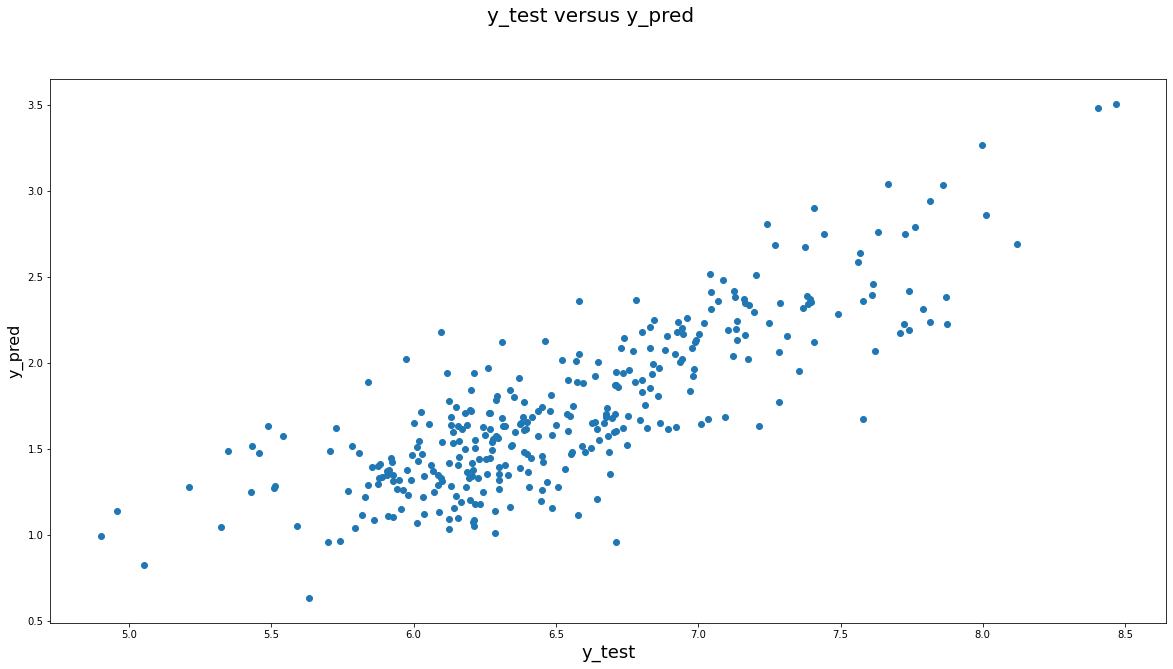

In [993]:
df_resultats_bp, y_pred=grid_regression(X_train,y_emission_train,X_test,y_emission_test,GradientBoostingRegressor,
                                        gradboost_params_best,df_resultats_bp,
                                     'GBR_bp',tableau=True)

## 4.3 Comparaison des performances 

In [994]:
comparatif = df_resultats_bp.sort_values(by=['Grid MSE','Grid RMSE','Grid R2'])
comparatif.style.hide_index()

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
GBR_bp,0.181596,0.557176,0.426140,74.956825,4.389760
SVR_bp,0.181777,0.556734,0.426353,75.116087,0.958299
RFR_bp,0.185742,0.547066,0.430978,74.907760,4.879570
Elastic_bp,0.191489,0.533050,0.437595,74.428330,0.096740
RIDGE_bp,0.197337,0.518791,0.444226,74.500446,0.131616
lasso_bp,0.204353,0.501682,0.452054,73.196648,0.130020
KNR_bp,0.228441,0.442943,0.477955,73.429800,0.115319


In [995]:
# creation d'un df pour l'utiliser plus tard pour comparaison des résultats
df1=comparatif.head(3).mean()

C:\Users\mehan\AppData\Local\Temp/ipykernel_31504/2046435800.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1=comparatif.head(3).mean()


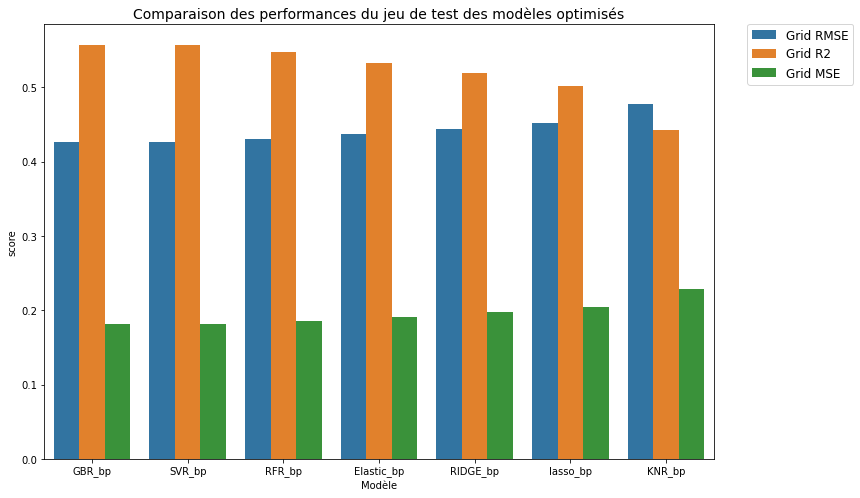

In [996]:
# comparaison sans la durée sur les critères 

df_compar = comparatif.head(7)
comparaison_score_melt = pd.melt(df_compar, id_vars=['Modèle'], value_name='score', value_vars=[
                                 'Grid RMSE', 'Grid R2','Grid MSE'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'])
plt.title(
    'Comparaison des performances du jeu de test des modèles optimisés', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

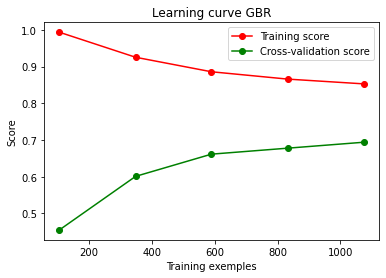

In [997]:
# learning curve GBR
estimator=GradientBoostingRegressor()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = gradboost_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train, y_energy_train)
plot_learning_curve(estimator_grid, 'Learning curve GBR',
                                 X_train, y_energy_train)

#### Bilan

## 4.4 Pertinence des variables , exemple du modèle du modèle GBR

In [877]:
estimator=GradientBoostingRegressor()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = gradboost_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train, y_emission_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'n_estimators': [200]})

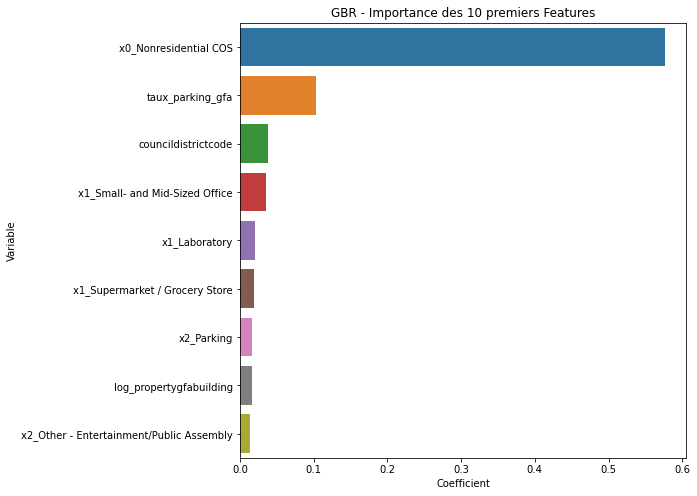

In [998]:
feature_importance=estimator.fit(X_train, y_emission_train).feature_importances_
oefficients = feature_importance
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), 
                            axis = 1).sort_values(by='Coefficient',ascending=False)
# visualisation des variables pertinentes
plt.figure(figsize=(8,8))
plt.title('GBR - Importance des 10 premiers Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(10),
            x = liste_coefs_gbr['Coefficient'].head(10))
plt.show()


In [880]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator_grid, random_state=1).fit(X_train, y_emission_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.7623 ± 0.0835,log_propertygfabuilding
0.1085 ± 0.0059,x1_Supermarket / Grocery Store
0.0472 ± 0.0048,age
0.0335 ± 0.0035,x1_Warehouse
0.0249 ± 0.0055,taux_second_gfa
0.0245 ± 0.0047,taux-largest_gfa
0.0212 ± 0.0076,x2_Supermarket/Grocery Store
0.0185 ± 0.0034,x2_Self-Storage Facility
0.0180 ± 0.0049,x1_Other
0.0173 ± 0.0056,x1_Hotel


# 4.4 Intérêt de l'EnergyStar Score sur la prédiction des émissions de CO2

In [952]:
# Jeu de données 
data_es= data.copy()
data_es.columns.tolist()

['Unnamed: 0',
 'osebuildingid',
 'buildingtype',
 'primarypropertytype',
 'councildistrictcode',
 'neighborhood',
 'numberofbuildings',
 'numberoffloors',
 'largestpropertyusetype',
 'secondlargestpropertyusetype',
 'thirdlargestpropertyusetype',
 'energystarscore',
 'siteenergyuse(kbtu)',
 'totalghgemissions',
 'address',
 'zipcode',
 'age',
 'log_siteenergyuse(kbtu)',
 'log_totalghgemissions',
 'taux_parking_gfa',
 'nombre_utilisation',
 'taux-largest_gfa',
 'taux_second_gfa',
 'taux_third_gfa',
 'log_propertygfabuilding',
 'lat_long']

In [953]:
#suppression des variables inutiles
data_es.drop(['Unnamed: 0'],axis=1,inplace=True)
data_es.drop(df_identification,axis=1,inplace=True)

In [894]:
data_es.shape

(1679, 25)

In [895]:
# Suppression des valeurs manquantes de la variables ENERGYSTARScore
data_es.dropna(axis=0, inplace=True)
data_es.shape

(1111, 25)

In [896]:
# Variables qualitatives
cols_cat_es = data_es.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_es

['buildingtype',
 'primarypropertytype',
 'neighborhood',
 'largestpropertyusetype',
 'secondlargestpropertyusetype',
 'thirdlargestpropertyusetype',
 'address',
 'lat_long']

In [897]:
# Variables quantitatives
cols_num_es = data_es.select_dtypes(include=[np.number]).columns.to_list()

cols_num_es

['osebuildingid',
 'councildistrictcode',
 'numberofbuildings',
 'numberoffloors',
 'energystarscore',
 'siteenergyuse(kbtu)',
 'totalghgemissions',
 'zipcode',
 'age',
 'log_siteenergyuse(kbtu)',
 'log_totalghgemissions',
 'taux_parking_gfa',
 'nombre_utilisation',
 'taux-largest_gfa',
 'taux_second_gfa',
 'taux_third_gfa',
 'log_propertygfabuilding']

In [898]:
# Suppression des variables cibles
cols_num_es.remove('siteenergyuse(kbtu)')
cols_num_es.remove('log_siteenergyuse(kbtu)')
cols_num_es.remove('totalghgemissions')
cols_num_es.remove('log_totalghgemissions')

In [899]:
# Matrice X
X_es = data_es[cols_cat_es+cols_num_es]
X_es.shape

(1111, 21)

In [900]:
# Analyse de la target 'log_totalghgemissions' 
y_es= data_es['log_totalghgemissions']
y_es.shape

(1111,)

In [901]:
#Découpage du jeu de données en train set et test set

X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(X_es, y_es, test_size=0.2, random_state=30)
    
print(f'X_train: {X_train_es.shape} - X_test : {X_test_es.shape}')
print(f'y_train : {y_train_es.shape} - y_test : {y_test_es.shape}')

X_train: (888, 21) - X_test : (223, 21)
y_train : (888,) - y_test : (223,)


In [902]:
X_train_cat=X_train_es[cols_cat_es]
X_train_cat

,buildingtype,primarypropertytype,neighborhood,largestpropertyusetype,secondlargestpropertyusetype,thirdlargestpropertyusetype,address,lat_long
1507,NonResidential,Worship Facility,NORTHEAST,Worship Facility,unused,unused,4554 12th Ave NE,"(47.64, 47.663](-122.32, -122.305]"
1065,NonResidential,K-12 School,DELRIDGE,K-12 School,unused,unused,9615 20th Ave. SW,"(47.499, 47.523](-122.366, -122.351]"
298,NonResidential,Large Office,DOWNTOWN,Office,unused,unused,1411 4TH AVE,"(47.593, 47.617](-122.351, -122.335]"
1364,NonResidential,Retail Store,NORTHEAST,Retail Store,unused,unused,809 NE 45 STREET,"(47.64, 47.663](-122.32, -122.305]"
327,NonResidential,Warehouse,GREATER DUWAMISH,Non-Refrigerated Warehouse,unused,unused,750 S Michigan St,"(47.546, 47.57](-122.335, -122.32]"
...,...,...,...,...,...,...,...,...
1303,NonResidential,Worship Facility,MAGNOLIA / QUEEN ANNE,Worship Facility,Parking,unused,2415 31st Ave,"(47.64, 47.663](-122.412, -122.397]"
1336,NonResidential,Warehouse,GREATER DUWAMISH,Non-Refrigerated Warehouse,unused,unused,4424 4th Ave. S.,"(47.546, 47.57](-122.335, -122.32]"
679,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,Office,unused,unused,2800 1st Avenue Room 140,"(47.617, 47.64](-122.366, -122.351]"
1384,NonResidential,Worship Facility,EAST,Worship Facility,unused,unused,400 E PIKE ST,"(47.593, 47.617](-122.335, -122.32]"


In [903]:
X_test_cat=X_test_es[cols_cat_es]
X_test_cat

,buildingtype,primarypropertytype,neighborhood,largestpropertyusetype,secondlargestpropertyusetype,thirdlargestpropertyusetype,address,lat_long
1559,NonResidential,Small- and Mid-Sized Office,Ballard,Office,Distribution Center,unused,3977 Leary Way NW,"(47.64, 47.663](-122.366, -122.351]"
274,NonResidential,Large Office,DOWNTOWN,Office,Parking,Other - Education,1325 4th Avenue,"(47.593, 47.617](-122.351, -122.335]"
308,NonResidential,Large Office,DOWNTOWN,Office,Parking,unused,1200 6th Avenue,"(47.593, 47.617](-122.335, -122.32]"
846,NonResidential,Mixed Use Property,LAKE UNION,Office,Parking,Bar/Nightclub,3417 Evanston Ave. N.,"(47.64, 47.663](-122.366, -122.351]"
1382,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,Office,Bank Branch,unused,666 S. Dearborn St,"(47.593, 47.617](-122.335, -122.32]"
...,...,...,...,...,...,...,...,...
564,NonResidential,Large Office,DOWNTOWN,Office,unused,unused,1915 Terry Ave,"(47.593, 47.617](-122.335, -122.32]"
1337,NonResidential,Warehouse,GREATER DUWAMISH,Non-Refrigerated Warehouse,Office,unused,4400 4TH AVE S,"(47.546, 47.57](-122.335, -122.32]"
981,NonResidential,Warehouse,GREATER DUWAMISH,Non-Refrigerated Warehouse,unused,unused,860 South Cambridge Street,"(47.499, 47.523](-122.335, -122.32]"
886,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,Office,unused,unused,1408 4th Avenue,"(47.593, 47.617](-122.351, -122.335]"


In [904]:
# Encodage
ohe = OneHotEncoder(sparse=False,handle_unknown ='ignore')
X_train_cat = ohe.fit_transform(X_train_cat)
X_train_cat = pd.DataFrame(columns=ohe.get_feature_names().tolist(),
                        data=X_train_cat)


In [905]:
X_test_cat= ohe.transform(X_test_cat)
X_test_cat = pd.DataFrame(columns=ohe.get_feature_names().tolist(),
                        data=X_test_cat)

In [906]:
X_train_cat

,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_Distribution Center,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Large Office,x1_Low-Rise Multifamily,...,"x7_(47.687, 47.71](-122.32, -122.305]","x7_(47.687, 47.71](-122.335, -122.32]","x7_(47.687, 47.71](-122.351, -122.335]","x7_(47.687, 47.71](-122.366, -122.351]","x7_(47.687, 47.71](-122.381, -122.366]","x7_(47.71, 47.734](-122.305, -122.289]","x7_(47.71, 47.734](-122.32, -122.305]","x7_(47.71, 47.734](-122.335, -122.32]","x7_(47.71, 47.734](-122.351, -122.335]","x7_(47.71, 47.734](-122.366, -122.351]"
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
885,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [907]:
X_test_cat

,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_Distribution Center,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Large Office,x1_Low-Rise Multifamily,...,"x7_(47.687, 47.71](-122.32, -122.305]","x7_(47.687, 47.71](-122.335, -122.32]","x7_(47.687, 47.71](-122.351, -122.335]","x7_(47.687, 47.71](-122.366, -122.351]","x7_(47.687, 47.71](-122.381, -122.366]","x7_(47.71, 47.734](-122.305, -122.289]","x7_(47.71, 47.734](-122.32, -122.305]","x7_(47.71, 47.734](-122.335, -122.32]","x7_(47.71, 47.734](-122.351, -122.335]","x7_(47.71, 47.734](-122.366, -122.351]"
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [908]:
#Standardisationr
rbs= RobustScaler()
X_train_num = rbs.fit_transform(X_train_es[cols_num_es])
X_test_num= rbs.transform(X_test_es[cols_num_es])

In [909]:
#remettre en dataframe
X_train_num=pd.DataFrame(X_train_num, columns=X_train_es[cols_num_es].columns.tolist())
X_test_num=pd.DataFrame(X_test_num,columns=X_test_es[cols_num_es].columns.tolist() )

In [910]:
X_train_num.isna().sum().sum()

0

In [911]:
X_train_num.shape

(888, 13)

In [912]:
X_train_cat.shape

(888, 1072)

In [913]:
X_train_cat.isna().sum().sum()

0

In [914]:
# X_train encodé et standardisé
X_train_es=pd.concat([X_train_num,X_train_cat.reindex(X_train_num.index)],axis=1)

In [915]:
X_train_es.shape

(888, 1085)

In [916]:
# X_test encodé et standardisé
X_test_es=pd.concat([X_test_num,X_test_cat.reindex(X_test_num.index)],axis=1)

In [917]:
X_train_es.shape

(888, 1085)

In [918]:
X_test_es.shape

(223, 1085)

In [919]:
y_train_es.shape

(888,)

In [920]:
y_test_es.shape

(223,)

In [921]:
print(X_train_es.isna().sum().sum())
print(X_test_es.isna().sum().sum())

0
0


#### Modélisation des 3 précedents estimateurs sur le dataset comrpenant la variable enerystarscor

In [922]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_resultats = pd.DataFrame(dtype='object')

In [923]:
# constitution d'un grid des hyperparamètres
rfr_params = {'n_estimators' : [10,50,100,300,500],'min_samples_leaf' : [1,3,5,10],'max_features': ['auto', 'sqrt'] }

svr_params = {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10],'tol':[0.001]}
gradboost_params = {'n_estimators':[10,50,100, 500, 1000],'random_state':[30]}


In [924]:
# fonction pour chercher les best_param

def grid_regression(X_train,y_train,X_test,y_test,estimator, grid,df_resultats,titre,affiche_tableau=True):
      
    estimator_grid_emission = GridSearchCV(estimator = estimator(), 
                      param_grid = grid,cv=5,verbose=5)
    
    time_start = time.time()
    
    estimator_grid_emission.fit(X_train, y_train)
   
    
    # Prédictions avec le test set
    y_pred =  estimator_grid_emission.predict(X_test)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Calcul des métriques
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Sauvegarde des performances
    
    df_resultats= df_resultats.append(pd.DataFrame({
         'Modèle': [titre],
          'Best_param':[estimator_grid_emission.best_params_],
        'Best_scor':[estimator_grid_emission.best_score_],
         'Grid R2': [r2],
         'Grid RMSE': [rmse],
         'Grid MAE': [mae],
         'Grid Accuracy': [accuracy],
         'Grid Time': [time_execution]
     }), ignore_index=True)
    
    if affiche_tableau:
        display(df_resultats.style.hide_index())
        
    return df_resultats, y_pred   

In [925]:
#SVR_es
df_resultats, y_pred=grid_regression(X_train_es,y_train_es,X_test_es,y_test_es,SVR,svr_params,df_resultats,
                                     'SVR_es',affiche_tableau=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.014 total time=   0.4s
[CV 2/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.019 total time=   0.4s
[CV 3/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.028 total time=   0.4s
[CV 4/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.007 total time=   0.4s
[CV 5/5] END C=0.001, epsilon=0.001, gamma=scale, tol=0.001;, score=0.028 total time=   0.4s
[CV 1/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.016 total time=   0.3s
[CV 2/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.020 total time=   0.4s
[CV 3/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.028 total time=   0.4s
[CV 4/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.008 total time=   0.4s
[CV 5/5] END C=0.001, epsilon=0.01, gamma=scale, tol=0.001;, score=0.028 total time=   0.3s
[CV 1/5] END 

[CV 2/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.578 total time=   0.2s
[CV 3/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.604 total time=   0.2s
[CV 4/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.568 total time=   0.2s
[CV 5/5] END C=10, epsilon=0.1, gamma=scale, tol=0.001;, score=0.576 total time=   0.2s
[CV 1/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.292 total time=   0.0s
[CV 2/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.316 total time=   0.0s
[CV 3/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.335 total time=   0.0s
[CV 4/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.177 total time=   0.0s
[CV 5/5] END C=10, epsilon=1, gamma=scale, tol=0.001;, score=0.326 total time=   0.0s


Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
SVR_es,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.575285,0.622607,0.382449,0.297344,77.807520,30.154259


In [926]:
# RFR_es
df_resultats, y_pred=grid_regression(X_train_es,y_train_es,X_test_es,y_test_es,RandomForestRegressor,rfr_params,df_resultats,
                                     'RFR_es',affiche_tableau=True)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.485 total time=   0.2s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.544 total time=   0.1s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.619 total time=   0.1s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.446 total time=   0.1s
[CV 5/5] END max_features=auto, min_samples_leaf=1, n_estimators=10;, score=0.574 total time=   0.1s
[CV 1/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.535 total time=   0.9s
[CV 2/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.619 total time=   0.9s
[CV 3/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.673 total time=   0.9s
[CV 4/5] END max_features=auto, min_samples_leaf=1, n_estimators=50;, score=0.517 total time=   0.8s
[CV 5/5] END max_features=aut

[CV 2/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.575 total time=   0.3s
[CV 3/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.590 total time=   0.4s
[CV 4/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.435 total time=   0.4s
[CV 5/5] END max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.592 total time=   0.4s
[CV 1/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.554 total time=   0.8s
[CV 2/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.564 total time=   0.8s
[CV 3/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.594 total time=   0.8s
[CV 4/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.440 total time=   0.8s
[CV 5/5] END max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.586 total time=   0.8s
[CV 1/5] END max_features=auto, min_samples_leaf=10, n_estimators=300;, score

[CV 4/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.272 total time=   0.1s
[CV 5/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.307 total time=   0.1s
[CV 1/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.274 total time=   0.4s
[CV 2/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.243 total time=   0.4s
[CV 3/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.265 total time=   0.4s
[CV 4/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.290 total time=   0.4s
[CV 5/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.270 total time=   0.4s
[CV 1/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.286 total time=   0.7s
[CV 2/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.259 total time=   0.7s
[CV 3/5] END max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.266

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
SVR_es,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.575285,0.622607,0.382449,0.297344,77.807520,30.154259
RFR_es,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}",0.593293,0.601051,0.393219,0.308236,76.649266,293.274461


In [927]:
# GBR_es
df_resultats, y_pred=grid_regression(X_train_es,y_train_es,X_test_es,y_test_es,GradientBoostingRegressor,gradboost_params,
                                     df_resultats,'GBR_es',affiche_tableau=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..n_estimators=10, random_state=30;, score=0.448 total time=   0.0s
[CV 2/5] END ..n_estimators=10, random_state=30;, score=0.487 total time=   0.0s
[CV 3/5] END ..n_estimators=10, random_state=30;, score=0.468 total time=   0.0s
[CV 4/5] END ..n_estimators=10, random_state=30;, score=0.393 total time=   0.0s
[CV 5/5] END ..n_estimators=10, random_state=30;, score=0.448 total time=   0.0s
[CV 1/5] END ..n_estimators=50, random_state=30;, score=0.577 total time=   0.5s
[CV 2/5] END ..n_estimators=50, random_state=30;, score=0.631 total time=   0.4s
[CV 3/5] END ..n_estimators=50, random_state=30;, score=0.633 total time=   0.5s
[CV 4/5] END ..n_estimators=50, random_state=30;, score=0.546 total time=   0.4s
[CV 5/5] END ..n_estimators=50, random_state=30;, score=0.628 total time=   0.4s
[CV 1/5] END .n_estimators=100, random_state=30;, score=0.563 total time=   0.9s
[CV 2/5] END .n_estimators=100, random_state=30;,

Modèle,Best_param,Best_scor,Grid R2,Grid RMSE,Grid MAE,Grid Accuracy,Grid Time
SVR_es,"{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'tol': 0.001}",0.575285,0.622607,0.382449,0.297344,77.807520,30.154259
RFR_es,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}",0.593293,0.601051,0.393219,0.308236,76.649266,293.274461
GBR_es,"{'n_estimators': 500, 'random_state': 30}",0.609184,0.656486,0.364879,0.296229,76.597217,91.535726


In [928]:
# Modélisation sur la base des best_param

In [929]:
# creation d'un fichier résultats best param
df_resultats_bp = pd.DataFrame(dtype='object')

In [931]:
# best param
rfr_params = {'n_estimators' : [300],'min_samples_leaf' : [1],'max_features': ['auto'] }

svr_params_best = {'C': [1], 'epsilon': [0.1], 'gamma': ['scale'], 'tol': [0.001]}

gradboost_params_best = {'n_estimators':[500],'random_state':[30]}

In [932]:
# Ajout de la visualisation dans la fonction 

def grid_regression(X_train,y_train,X_test,y_test,estimator, grid,df_resultats_bp,titre,affiche_tableau=True):
      
    estimator_grid_emission = GridSearchCV(estimator = estimator(), 
                      param_grid = grid,cv=5,verbose=0)
    
    time_start = time.time()
    
    # Predictions avec le train set
    estimator_grid_emission.fit(X_train, y_train)
   
    
    # Prédictions avec le test set
    y_pred =  estimator_grid_emission.predict(X_test)
    
    # Top fin d'exécution
    time_end = time.time()
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    # Calcul des métriques
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # durée d'exécution
    time_execution = time_end - time_start
    
    
    # Visualisation des prédictions / valeurs réélles du jeu de test 
    fig = plt.figure(figsize=(20, 10))
    plt.scatter(y_test_es, y_pred)
    fig.suptitle('y_test versus y_pred', fontsize=20)
    plt.xlabel('y_test', fontsize=18)
    plt.ylabel('y_pred', fontsize=16)
    
    # Sauvegarde des performances
    
    df_resultats_bp= df_resultats_bp.append(pd.DataFrame({
         'Modèle': [titre],
        'Grid MSE':[mse],
         'Grid R2': [r2],
         'Grid RMSE': [rmse],
         'Grid Accuracy': [accuracy],
         'Grid Time_bp': [time_execution]
        }), ignore_index=True)
    
    if affiche_tableau:
        display(df_resultats_bp.style.hide_index())
        
    return df_resultats_bp, y_pred

### SVR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
SVR_es,0.146267,0.622607,0.382449,77.807520,1.875328


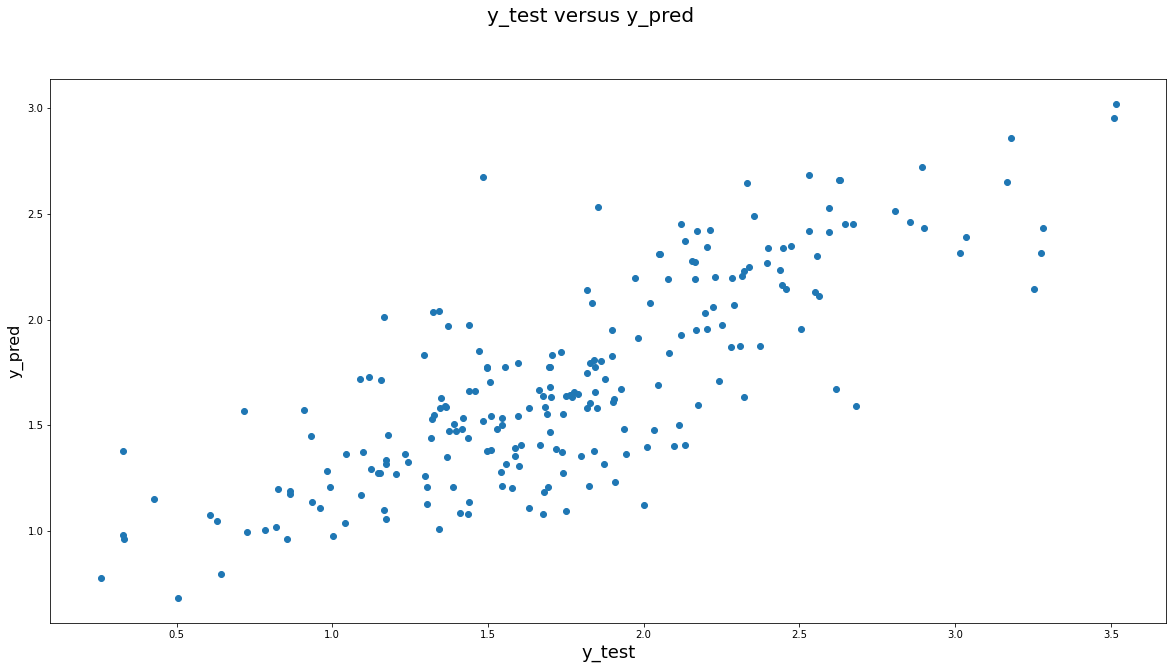

In [933]:
df_resultats_bp, y_pred=grid_regression(X_train_es,y_train_es,X_test_es,y_test_es,SVR,svr_params_best,df_resultats_bp,
                                     'SVR_es',affiche_tableau=True)

### RFR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
SVR_es,0.146267,0.622607,0.382449,77.807520,1.875328
RFR_es,0.158655,0.590644,0.398315,76.596550,7.594728


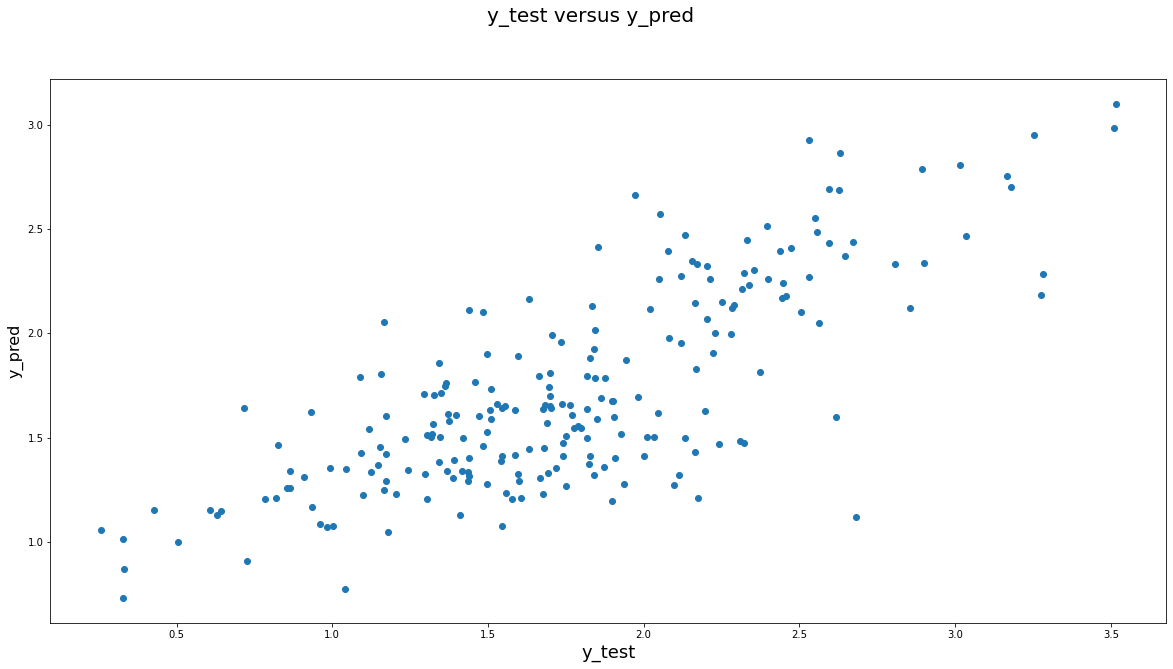

In [934]:

df_resultats_bp, y_pred=grid_regression(X_train_es,y_train_es,X_test_es,y_test_es,RandomForestRegressor,rfr_params_best,
                                        df_resultats_bp,
                                     'RFR_es',affiche_tableau=True)

### GBR Optimisé

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
SVR_es,0.146267,0.622607,0.382449,77.807520,1.875328
RFR_es,0.158655,0.590644,0.398315,76.596550,7.594728
GBR_es,0.133136,0.656486,0.364879,76.597217,30.682970


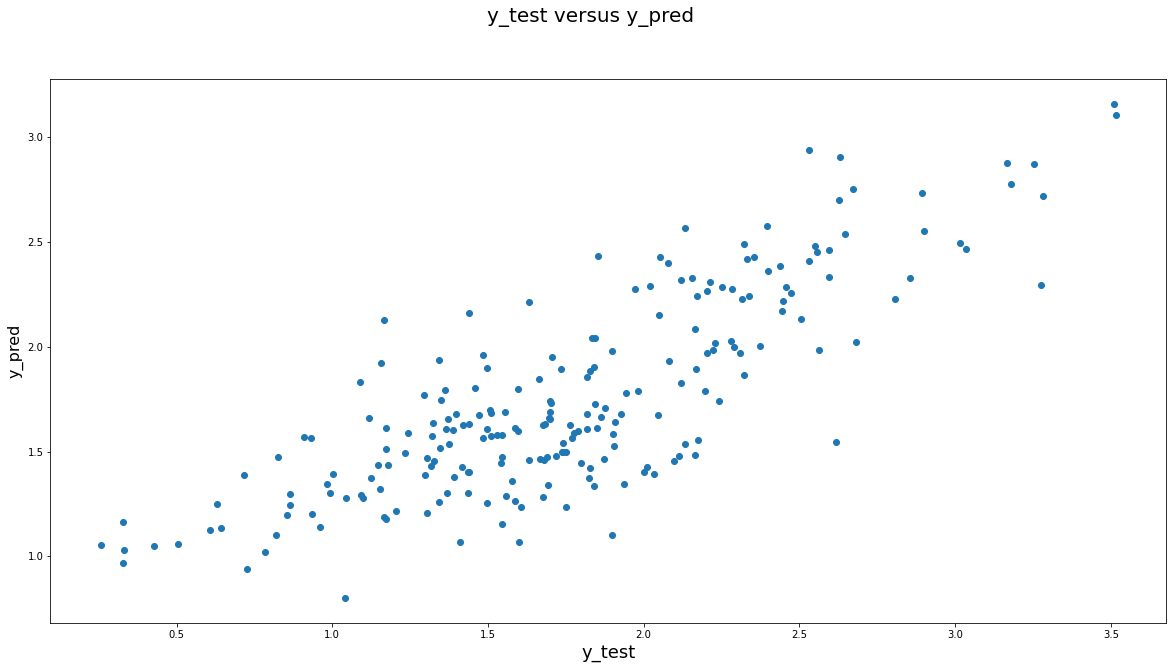

In [935]:
df_resultats_bp, y_pred=grid_regression(X_train_es,y_train_es,X_test_es,y_test_es,GradientBoostingRegressor,
                                        gradboost_params_best,df_resultats_bp,
                                     'GBR_es',affiche_tableau=True)

In [936]:
comparatif = df_resultats_bp.sort_values(by=['Grid MSE','Grid RMSE','Grid R2'])
comparatif.style.hide_index()

Modèle,Grid MSE,Grid R2,Grid RMSE,Grid Accuracy,Grid Time_bp
GBR_es,0.133136,0.656486,0.364879,76.597217,30.682970
SVR_es,0.146267,0.622607,0.382449,77.807520,1.875328
RFR_es,0.158655,0.590644,0.398315,76.596550,7.594728


In [974]:
df2=comparatif.mean()

C:\Users\mehan\AppData\Local\Temp/ipykernel_31504/1788553638.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df2=comparatif.mean()


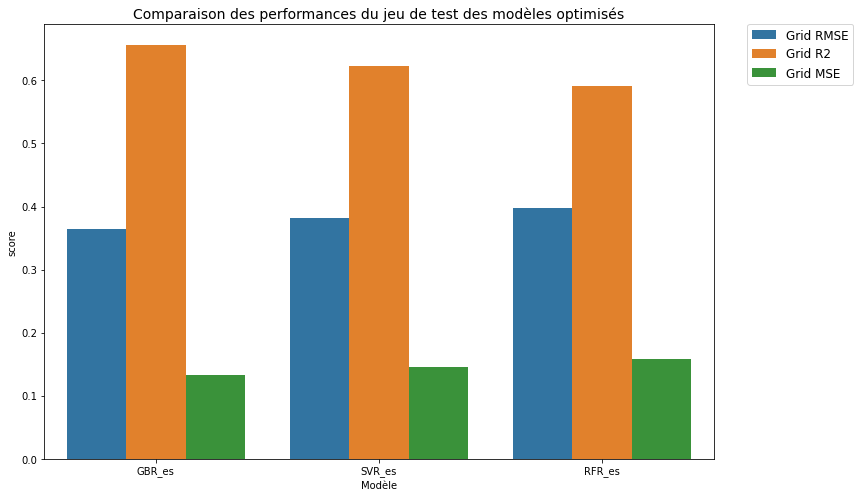

In [968]:
# comparaison sans la durée sur les critères 

df_compar = comparatif.head(3)
comparaison_score_melt = pd.melt(df_compar, id_vars=['Modèle'], value_name='score', value_vars=[
                                 'Grid RMSE', 'Grid R2','Grid MSE'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'])
plt.title(
    'Comparaison des performances du jeu de test des modèles optimisés', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

### bilan

In [999]:
# dataframe des métriques sans et avec energystarscor(ES)
dfc=pd.concat([df1,df2],axis=1)

In [1000]:
variables=['Sans ENERGY STAR','Avec ENERGY STAR']

In [1001]:
dfc.columns=[variables]

In [1002]:
dfc

,Sans ENERGY STAR,Avec ENERGY STAR
Grid MSE,0.183038,0.146019
Grid R2,0.553659,0.623246
Grid RMSE,0.427824,0.381881
Grid Accuracy,74.993558,77.000429
Grid Time_bp,3.409210,13.384342


In [ ]:
# imortance des features sur la data set avec ES 

In [959]:
# déterminons les coef
estimator=GradientBoostingRegressor()
estimator_grid = GridSearchCV(estimator = estimator, 
                      param_grid = gradboost_params_best,cv=5,verbose=0)
estimator_grid.fit(X_train_es, y_train_es)
feature_importance=estimator.fit(X_train_es, y_train_es).feature_importances_
coefficients = feature_importance
liste_coefs_gbr = pd.concat((pd.DataFrame(X_train_es.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), 
                            axis = 1).sort_values(by='Coefficient',ascending=False)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'n_estimators': [500], 'random_state': [30]})

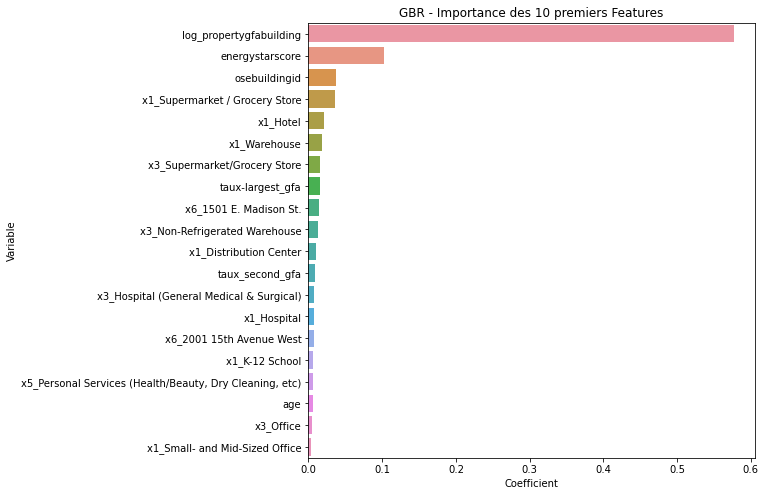

In [961]:
# visualisation des variables pertinentes
plt.figure(figsize=(8,8))
plt.title('GBR - Importance des 10 premiers Features')
sns.barplot(y = liste_coefs_gbr['Variable'].head(20),
            x = liste_coefs_gbr['Coefficient'].head(20))
plt.show()


In [956]:
# permutation 
perm = PermutationImportance(estimator_grid, random_state=1).fit(X_train_es, y_train_es)
eli5.show_weights(perm, feature_names = X_train_es.columns.tolist())

Weight,Feature
0.8875 ± 0.0895,log_propertygfabuilding
0.1215 ± 0.0048,energystarscore
0.0393 ± 0.0082,x1_Supermarket / Grocery Store
0.0241 ± 0.0069,x1_Warehouse
0.0218 ± 0.0019,osebuildingid
0.0155 ± 0.0037,taux-largest_gfa
0.0143 ± 0.0024,age
0.0143 ± 0.0047,x6_1501 E. Madison St.
0.0093 ± 0.0012,taux_second_gfa
0.0091 ± 0.0031,x3_Non-Refrigerated Warehouse
